In [1]:
import os
import sys
import pdb
import re
import json
import copy
import pickle
import glob
import tqdm
import importlib
import numpy as np
import pandas as pd
import pingouin as pg
import soundfile as sf
import soxr
import scipy.signal
import textwrap

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import util

sys.path.append('/om2/user/msaddler/tfauditoryutil')
import util_pitchnet_psychophysics

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_stimuli
import util_misc

tqdm.tqdm.pandas()

dict_tag_expt = {
    'localization': {
        'snr_dependency': 'Sound localization in noise',
        'itd_ild_weighting': 'ITD / ILD cue weighting (Macpherson & Middlebrooks, 2002)',
        'maa_azimuth': 'Minimum audible angle vs. azimuth (Mills, 1958)',
        # 'maa_frequency': 'Minimum audible angle vs. frequency (Mills, 1958)',
        'itd_threshold': 'ITD lateralization vs. frequency (Brughera et al., 2013)',
        'new_ears': 'Effect of changing ears (Hofman et al., 1998)',
        'spectral_smoothing': 'Effect of smoothing spectral cues (Kulkarni & Colburn, 1998)',
        'mp_spectral_cues': 'Median plane spectral cues (Hebrank & Wright, 1974)',
        'precedence_effect_localization': 'Precedence effect (Litovsky & Godar, 2010)',
        'bandwidth_dependency': 'Bandwidth dependency (Yost & Zhong, 2014)',
    },
    'spkr_word': {
        'kell_like_word': 'Word recognition as a function of SNR and noise condition',
        'speech_in_synthetic_textures': 'Word recognition in 43 distinct auditory textures',
        'pitch_altered_word': 'Word recognition with pitch-altered speech',
        'pitch_altered_spkr': 'Voice recognition with pitch-altered speech',
        # 'spkr_discrimination_timit_ssn': 'Voice discrimination in stationary and modulated noise',
        # 'kell_like_word_dip_listening': 'Word recognition in stationary and modulated noise',
        'hopkins_moore_2009_word': 'Effect of tone vocoding on word recognition in noise (Hopkins & Moore, 2009)',
    },
}

dict_tag_model = {
    'localization': {
        'human': "human",
        '3000': "/om2/user/msaddler/tfauditoryutil/saved_models/models_localize/v01/IHC3000Hz_anf384H160M096L/archFrancl??",
        '1000': "/om2/user/msaddler/tfauditoryutil/saved_models/models_localize/v01/IHC1000Hz_anf384H160M096L/archFrancl??",
        '320': "/om2/user/msaddler/tfauditoryutil/saved_models/models_localize/v01/IHC0320Hz_anf384H160M096L/archFrancl??",
        '50': "/om2/user/msaddler/tfauditoryutil/saved_models/models_localize/v01/IHC0050Hz_anf384H160M096L/archFrancl??",
        '3000_delayed': "/om2/user/msaddler/tfauditoryutil/saved_models/models_localize/v01/grouped/before_pool_factor2/IHC3000Hz_anf384H160M096L/archFrancl??",
        '3000_simple': "/om2/user/msaddler/tfauditoryutil/saved_models/models_localize/v01/spont0_simplified_IHC3000/archFrancl??",
        '1000_simple': "/om2/user/msaddler/tfauditoryutil/saved_models/models_localize/v01/spont0_simplified_IHC1000/archFrancl??",
        '320_simple': "/om2/user/msaddler/tfauditoryutil/saved_models/models_localize/v01/spont0_simplified_IHC0320/archFrancl??",
        '50_simple': "/om2/user/msaddler/tfauditoryutil/saved_models/models_localize/v01/spont0_simplified_IHC0050/archFrancl??",
        '3000_delayed_simple': "/om2/user/msaddler/tfauditoryutil/saved_models/models_localize/v01/grouped/before_pool_factor2/spont0_simplified_IHC3000/archFrancl??",
    },
    'spkr_word': {
        "50": "saved_models/augmented_2022JAN/taskSW/IHC0050Hz_anf384H160M096L/arch0_00??",
        "320": "saved_models/augmented_2022JAN/taskSW/IHC0320Hz_anf384H160M096L/arch0_00??",
        "1000": "saved_models/augmented_2022JAN/taskSW/IHC1000Hz_anf384H160M096L/arch0_00??",
        "3000": "saved_models/augmented_2022JAN/taskSW/IHC3000Hz_anf384H160M096L/arch0_00??",
        "50_simple": "saved_models/augmented_2022JAN/taskSW/spont0_simplified_IHC0050/arch0_00??",
        "320_simple": "saved_models/augmented_2022JAN/taskSW/spont0_simplified_IHC0320/arch0_00??",
        "1000_simple": "saved_models/augmented_2022JAN/taskSW/spont0_simplified_IHC1000/arch0_00??",
        "3000_simple": "saved_models/augmented_2022JAN/taskSW/spont0_simplified_IHC3000/arch0_00??",
        "50_spkr": "saved_models/augmented_2022JAN/task_S/IHC0050Hz_anf384H160M096L/arch0_00??",
        "320_spkr": "saved_models/augmented_2022JAN/task_S/IHC0320Hz_anf384H160M096L/arch0_00??",
        "1000_spkr": "saved_models/augmented_2022JAN/task_S/IHC1000Hz_anf384H160M096L/arch0_00??",
        "3000_spkr": "saved_models/augmented_2022JAN/task_S/IHC3000Hz_anf384H160M096L/arch0_00??",
        "50_word": "saved_models/augmented_2022JAN/task_W/IHC0050Hz_anf384H160M096L/arch0_00??",
        "320_word": "saved_models/augmented_2022JAN/task_W/IHC0320Hz_anf384H160M096L/arch0_00??",
        "1000_word": "saved_models/augmented_2022JAN/task_W/IHC1000Hz_anf384H160M096L/arch0_00??",
        "3000_word": "saved_models/augmented_2022JAN/task_W/IHC3000Hz_anf384H160M096L/arch0_00??",
    },
}

def map_tag_model_to_x(tag_model):
    if 'IHC3000' in tag_model:
        return 3000
    elif 'IHC1000' in tag_model:
        return 1000
    elif 'IHC0320' in tag_model:
        return 320
    elif 'IHC0050' in tag_model:
        return 50
    else:
        raise ValueError(f'Did not recognize {tag_model=}')

def get_p_val(y_null, y):
    """
    """
    # p = np.mean(y > y_null)
    null_dist = scipy.stats.norm(loc=np.mean(y_null), scale=np.std(y_null))
    p = null_dist.cdf(y)
    if p > 0.5:
        p = 1 - p
    p = p * 2
    return p


/om2/user/msaddler/.conda/envs/tf/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [7]:
importlib.reload(util)

list_key_task = [
    'localization',
    # 'pitchnet',
    'spkr_word',
]
dict_list_k = {
    'localization': ['3000_delayed', '3000', '1000', '320', '50'],
    'spkr_word': ['3000', '1000', '320', '50'],
}

list_df_mean = []
for key_task in list_key_task:
    df = pd.read_pickle(f'data/human_model_comparison_metrics_{key_task}.pkl')
    list_tag_model = [dict_tag_model[key_task][k] for k in dict_list_k[key_task]]
    list_tag_expt = list(dict_tag_expt[key_task].keys())
    df = df[np.logical_and.reduce([
        df.tag_model.isin(list_tag_model),
        df.tag_expt.isin(list_tag_expt),
    ])]
    print(key_task, list_tag_expt)
    df_normalized = util.normalize_comparison_metrics(df)
    df_mean = util.average_comparison_metrics(df_normalized)
    list_df_mean.append(df_mean)
df_mean = pd.concat(list_df_mean)
len(df_mean)


localization ['snr_dependency', 'itd_ild_weighting', 'maa_azimuth', 'itd_threshold', 'new_ears', 'spectral_smoothing', 'mp_spectral_cues', 'precedence_effect_localization', 'bandwidth_dependency']
spkr_word ['kell_like_word', 'speech_in_synthetic_textures', 'pitch_altered_word', 'pitch_altered_spkr', 'hopkins_moore_2009_word']


9

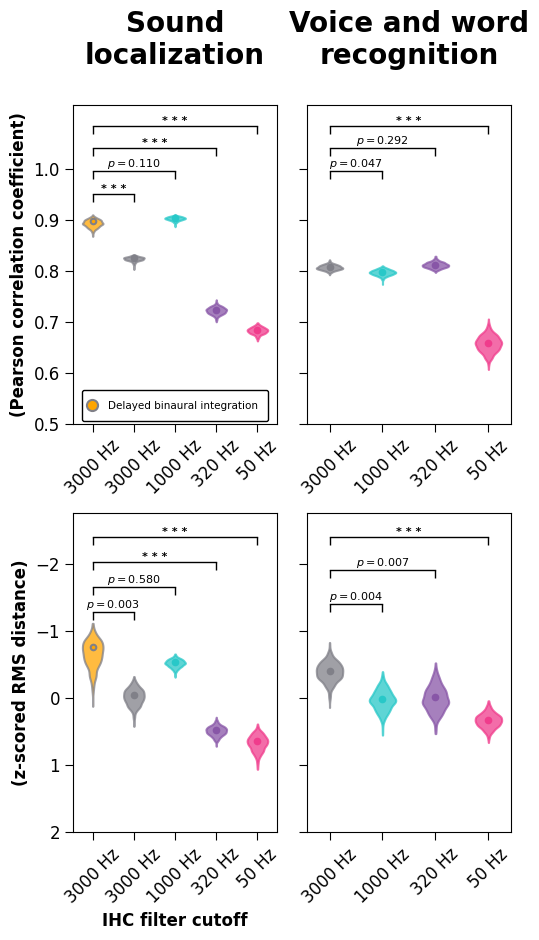

In [9]:
list_key_metric = ['pearsonr', 'rmse']

fig, ax_arr = plt.subplots(
    nrows=len(list_key_metric),
    ncols=len(list_key_task),
    figsize=(8/3 * len(list_key_task), 9.5),
    sharey='row',
    sharex=False)
ax_arr = np.array(ax_arr).reshape([len(list_key_metric), len(list_key_task)])
for r, key_metric in enumerate(list_key_metric):
    for c, key_task in enumerate(list_key_task):
        ax = ax_arr[r, c]
        list_tag_model = [dict_tag_model[key_task][k] for k in dict_list_k[key_task]]
        tag_model_null = list_tag_model[0]
        dfi = df_mean[np.logical_and.reduce([
            df_mean['tag_expt'] == f'AVERAGE',
            df_mean['tag_model'] == tag_model_null,
        ])]
        assert len(dfi) == 1
        y_null = dfi.iloc[0][f'bootstrap_list_{key_metric}']
        xticks = []
        xticklabels = []
        for itr_model, tag_model in enumerate(list_tag_model):
            x = itr_model
            dfi = df_mean[np.logical_and.reduce([
                df_mean['tag_expt'] == f'AVERAGE',
                df_mean['tag_model'] == tag_model,
            ])]
            assert len(dfi) == 1
            dfi = dfi.iloc[0]
            color, label = util.get_color_and_label_from_model_tag(tag_model)
            label = label.replace(' IHC filter', '')
            if 'group' in tag_model:
                facecolor = 'orange'
                str_label = 'Delayed binaural integration'
            else:
                facecolor = color
                str_label = None
            parts = ax.violinplot(
                dfi[f'bootstrap_list_{key_metric}'],
                positions=[x],
                showmeans=False,
                showextrema=False)
            for k in parts.keys():
                if not k == 'bodies':
                    parts[k].set_color(color)
                    parts[k].set_linewidth(2)
            for pc in parts['bodies']:
                pc.set_facecolor(facecolor)
                pc.set_edgecolor(color)
                pc.set_linewidth(1.5)
                pc.set_alpha(0.75)
            ax.plot(
                x,
                dfi[key_metric],
                color=color,
                marker='o',
                ms=4,
                mew=1.5,
                label=str_label,
                mfc=facecolor)
            xticks.append(x)
            xticklabels.append(label)
            
            if itr_model > 0:
                if key_metric == 'pearsonr':
                    list_y1 = np.arange(0.95, 1.11, 0.045).tolist()
                    if key_task == 'localization':
                        list_y1 = [list_y1[0] - (list_y1[1] - list_y1[0])] + list_y1
                else:
                    list_y1 = np.linspace(-0.9, -2.4, len(list_tag_model)).tolist()
                x0 = xticks[0]
                x1 = x
                y1 = list_y1[itr_model]
                ax.plot([x0, x1], [y1, y1], color='k', marker=3, lw=1, mew=1)
                p_val = get_p_val(y_null, dfi[key_metric])
                str_text = '* * *' if p_val < 0.001 else '$p={:.3f}$'.format(p_val)
                ax.text((x0 + x1) / 2, y1 * 1., str_text, ha='center', va='bottom', fontsize=8, fontweight='bold')
        
        if key_task == 'localization':
            str_title = 'Sound\nlocalization\n'
        elif key_task == 'pitchnet':
            str_title = 'Pitch\nperception\n'
        else:
            str_title = 'Voice and word\nrecognition\n'
        kwargs_format_axes = {
            'str_title': str_title if r == 0 else None,
            'str_xlabel': 'IHC filter cutoff' if (c == 0) and (r == 1) else None,
            'xticks': xticks,
            'xticklabels': xticklabels if r == 1 else [],
            'fontsize_title': 20,
            'fontweight_title': 'bold',
            'fontweight_labels': 'bold',
        }
        if key_metric == 'pearsonr':
            kwargs_format_axes_update = {
                'ylimits': [0.5, 1.125],
                'yticks': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                'str_ylabel': "(Pearson correlation coefficient)" if c == 0 else None,
            }
        else:
            kwargs_format_axes_update = {
                'ylimits': [2, -2.75],
                'yticks': [2, 1, 0, -1, -2],
                'str_ylabel': "(z-scored RMS distance)" if c == 0 else None,
            }
        kwargs_format_axes.update(kwargs_format_axes_update)
        ax = util_figures.format_axes(ax, **kwargs_format_axes)
        if 1:#r == 1:
            ax.set_xticks(xticks, labels=xticklabels, rotation=45)
        ax.set_facecolor('w')
        if r == 0 and c == 0:
            kwargs_legend = {
                'frameon': True,
                'framealpha': 1,
                'edgecolor': 'k',
                'borderpad': 1,
                'borderaxespad': 0.25,
                'loc': 'lower center',
                'handletextpad': 1.5,
                'handlelength': 0,
                'markerscale': 2,
                'fontsize': 7.5,
            }
            ax.legend(**kwargs_legend)
fig.patch.set_facecolor('none')
plt.tight_layout()
plt.show()

# fn_fig = f'figures_poster/results_average_human_model_similarity.pdf'
# fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=False)
# print(fn_fig)


In [ ]:
# list_key_task = [
#     'localization',
#     # 'pitchnet',
#     'spkr_word',
# ]

# map_tag_expt_to_label = {
#     'mcpherson_snr': 'Pitch discrimination with pure and complex tones in noise (McPherson et al., 2022)',
#     'bernox2005': 'Pitch discrimination vs. harmonic number and phase (Bernstein & Oxenham, 2005)',
#     'altphasecomplexes': 'Pitch of alternating-phase harmonic complexes (Shackleton & Carlyon, 1994)',
#     'freqshiftedcomplexes': 'Pitch of frequency-shifted complexes (Moore & Moore, 2003)',
#     'mistunedharmonics': 'Pitch of complexes with individually mistuned harmonics (Moore, 1985)',
#     'transposedtones': 'Pitch discrimination with pure and transposed tones (Oxenham et al., 2004)',
#     'pure_tone_spl': 'Effect of level on pure tone frequency discrimination (Wier et al., 1977)',
    
#     'snr_dependency': 'Sound localization in noise',
#     'itd_ild_weighting': 'ITD / ILD cue weighting (Macpherson & Middlebrooks, 2002)',
#     'maa_azimuth': 'Minimum audible angle vs. azimuth (Mills, 1958)',
#     # 'maa_frequency': 'Minimum audible angle vs. frequency (Mills, 1958)',
#     'itd_threshold': 'ITD lateralization vs. frequency (Brughera et al., 2013)',
#     'new_ears': 'Effect of changing ears (Hofman et al., 1998)',
#     'spectral_smoothing': 'Effect of smoothing spectral cues (Kulkarni & Colburn, 1998)',
#     'mp_spectral_cues': 'Median plane spectral cues (Hebrank & Wright, 1974)',
#     'precedence_effect_localization': 'Precedence effect (Litovsky & Godar, 2010)',
#     'bandwidth_dependency': 'Bandwidth dependency of localization (Yost & Zhong, 2014)',
    
#     'pitch_altered_spkr_word': 'Voice and word recognition with pitch-altered speech',
#     'kell_like_word': 'Word recognition in real-world noise conditions',
#     'spkr_discrimination_timit_ssn': 'Voice discrimination in stationary and modulated noise',
#     'kell_like_word_dip_listening': 'Word recognition in stationary and modulated noise',
#     'hopkins_moore_2009_word': 'Effect of tone vocoding on word recognition in noise (Hopkins & Moore, 2009)',
# }

# ci_percentile = 95
# key_metric = 'pearsonr'

# list_df_mean = []
# for key_task in list_key_task:
#     df = pd.read_pickle(f'data/human_model_comparison_metrics_{key_task}.pkl')
#     if key_task == 'spkr_word':
#         df = df[df['tag_model'].str.contains('taskSW')]
#     map_tag_model_to_label = {}
#     for tag_model in df.tag_model.unique():
#         color, label = util.get_color_and_label_from_model_tag(tag_model)
#         label = 'ihc{:04d}'.format(int(label.split(' ')[0]))
#         if 'pool' in tag_model:
#             label = label + '_delayed'
#         if 'simpl' in tag_model:
#             label = label + '_simple'
#         else:
#             label = label + '_bez2018'
#         map_tag_model_to_label[tag_model] = label
#     df['tag_model'] = df['tag_model'].map(map_tag_model_to_label)
#     df = df[df['tag_expt'].isin(map_tag_expt_to_label.keys())]
#     n_expt = df['tag_expt'].nunique()
#     list_tag_model = [
#         'ihc3000_bez2018',
#         'ihc1000_bez2018',
#         'ihc0320_bez2018',
#         'ihc0050_bez2018',
#     ]
#     if 'localization' in key_task:
#         list_tag_model = ['ihc3000_delayed_bez2018'] + list_tag_model
#     n_model = len(list_tag_model)
#     width = 0.12 * (5 / n_model)
#     list_x = (np.arange(n_model) - (n_model -  1) / 2) * width
#     fig, ax = plt.subplots(figsize=(n_expt * 2, 4))
#     itr_expt = 0
#     xticks = []
#     xticklabels = []
#     for tag_expt in map_tag_expt_to_label.keys():
#         if tag_expt in df['tag_expt'].values:
#             xticks.append(itr_expt)
#             xticklabels.append(map_tag_expt_to_label[tag_expt])
#             for x, tag_model in zip(list_x + itr_expt, list_tag_model):
#                 color, label = util.get_color_and_label_from_model_tag(tag_model)
#                 ec, lw = ('k', 1.0)
#                 hatch = None
#                 if 'delayed' in tag_model:
#                     ec, lw = (color, 2.0)
#                     hatch = '//////'
#                     color = 'orange'
#                     label = '3000 Hz IHC filter (delayed binaural integration)'
#                 dfi = df[np.logical_and.reduce([
#                     df['tag_expt'] == tag_expt,
#                     df['tag_model'] == tag_model,
#                 ])]
#                 if len(dfi) == 1:
#                     dfi = dfi.iloc[0]
#                     y = dfi[key_metric]
#                     yerr = 2 * np.std(dfi[f'bootstrap_list_{key_metric}'])
#                     ci = np.percentile(
#                         dfi[f'bootstrap_list_{key_metric}'],
#                         [(100 - ci_percentile) / 2, ci_percentile + (100 - ci_percentile) / 2])
#                     yerr = np.array([y - ci[0], ci[1] - y]).reshape([2, 1])
#                     ax.bar(
#                         x,
#                         y,
#                         yerr=yerr,
#                         width=width,
#                         facecolor=color,
#                         edgecolor=ec,
#                         lw=lw,
#                         hatch=hatch,
#                         capsize=20 * width,
#                         label=label if itr_expt == 0 else None)
#             itr_expt += 1
#     for itr0 in range(len(xticklabels)):
#         ax.axvline(
#             itr0 - 0.5,
#             color='k',
#             lw=1)
#     kwargs_legend = {
#         'loc': 'upper left',
#         'frameon': True,
#         'framealpha': 1,
#         'facecolor': 'w',
#         'fontsize': 12,
#         'ncol': len(list_tag_model),
#         'columnspacing': 1.5,
#         'handletextpad': 0.5,
#         'borderaxespad': 0,
#         'borderpad': 0.75,
#         'edgecolor': 'k',
#     }
#     ax.legend(**kwargs_legend)
#     kwargs_format_axes = {
#         'ylimits': [0, 1.3],
#         'xlimits': [-0.5, len(xticklabels) - 0.5],
#         'yticks': np.arange(0, 1.1, 0.2),
#         'fontsize_ticks': 12,
#         'xticks': xticks,
#         'xticklabels': xticklabels,
#         'str_ylabel': 'Human-model similarity ($r$)'
#     }
#     ax = util_figures.format_axes(ax, **kwargs_format_axes)
#     ax = util.wrap_xticklabels(ax, 16, rotation=0, weight=None, size=12)
#     for label in ax.get_xticklabels():
#         if 'average' in label.get_text().lower():
#             label.set_fontweight('bold')
#             label.set_fontsize(16)
#     ax.set_facecolor('w')
#     fig.patch.set_facecolor('none')
#     plt.tight_layout()
#     plt.show()
    
#     # fn_fig = f'figures_poster/results_human_model_similarity_{key_metric}_{key_task}.pdf'
#     # fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=False)
#     # print(fn_fig)


/tmp/ipykernel_28199/3662803893.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


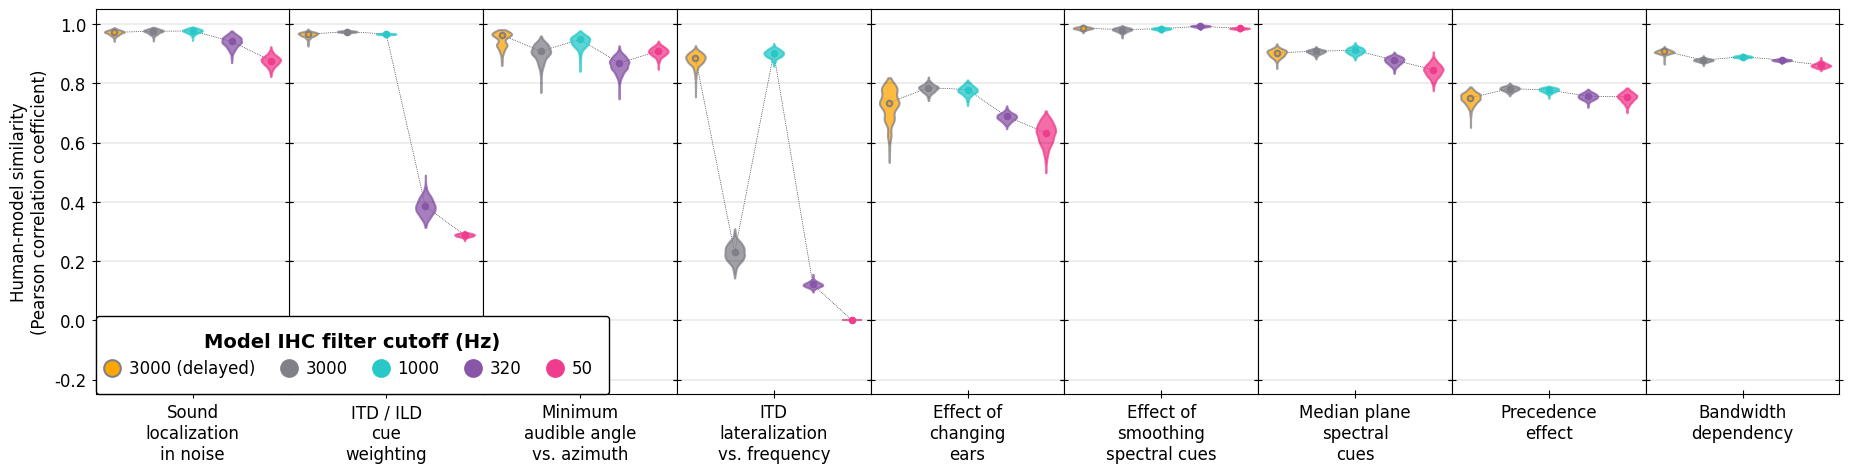

/tmp/ipykernel_28199/3662803893.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


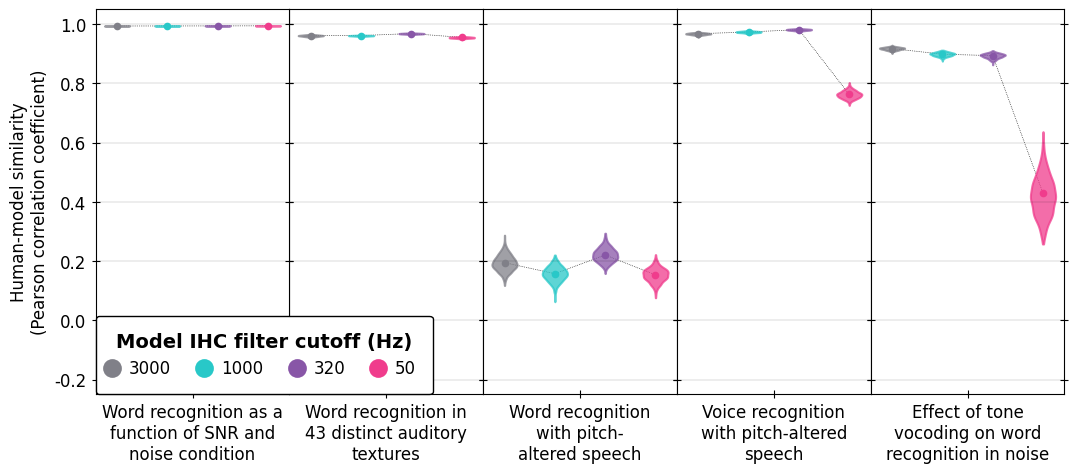

/tmp/ipykernel_28199/3662803893.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


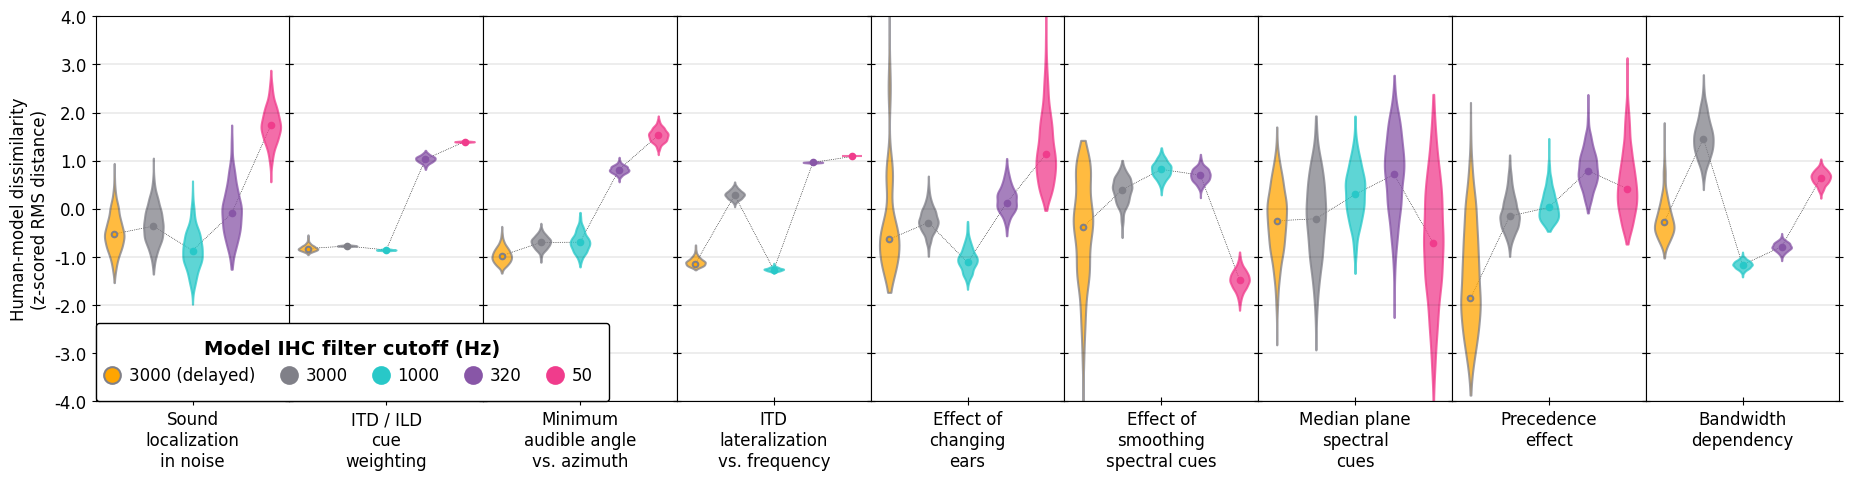

/tmp/ipykernel_28199/3662803893.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


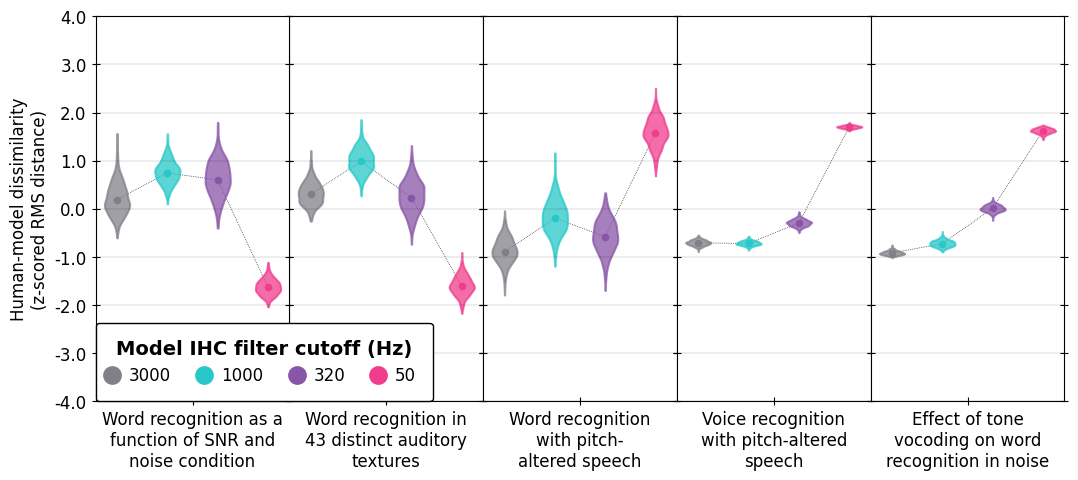

In [10]:
importlib.reload(util)

for key_metric in ['pearsonr', 'rmse']:
    dict_list_k = {
        'localization': ['3000_delayed', '3000', '1000', '320', '50'],
        'spkr_word': ['3000', '1000', '320', '50'],
    }
    # for _ in dict_list_k.keys():
    #     dict_list_k[_] = [k + '_simple' for k in dict_list_k[_]]
    
    for key_task, map_tag_expt_to_label in dict_tag_expt.items():
        df = pd.read_pickle(f'data/human_model_comparison_metrics_{key_task}.pkl')
        list_tag_model = [dict_tag_model[key_task][k] for k in dict_list_k[key_task]]
        list_tag_expt = list(dict_tag_expt[key_task].keys())
        df = df[np.logical_and.reduce([
            df.tag_model.isin(list_tag_model),
            df.tag_expt.isin(list_tag_expt),
        ])]
        df = util.normalize_comparison_metrics(df)
        df = pd.concat([df, util.average_comparison_metrics(df)])    
        n_expt = len(map_tag_expt_to_label.keys())
        # ncols, nrows = (5, n_expt // 5)
        ncols, nrows = (n_expt, 1)
        fig, ax_arr = plt.subplots(
            figsize=(2.5 * ncols, 5 * nrows),
            nrows=nrows,
            ncols=ncols,
            gridspec_kw={'hspace': 0.35, 'wspace': 0.0})
        ax_arr = ax_arr.reshape([nrows, ncols])
        for itr_ax, tag_expt in enumerate(map_tag_expt_to_label.keys()):
            r = itr_ax // ncols
            c = itr_ax % ncols
            ax = ax_arr[r, c]
            str_title = map_tag_expt_to_label[tag_expt]
            if ' (' in str_title:
                str_title = str_title[:str_title.find(' (')]
            str_title = textwrap.fill(str_title, width=np.ceil(len(str_title) / 3) + 3, break_long_words=False)
            if 'average' in str_title.lower():
                str_title = '\n' + r'$\bf{AVERAGE}$' + '\n'
            if str_title.count('\n') < 2:
                str_title = str_title + '\n'
            if key_metric == 'pearsonr':
                str_ylabel = 'Human-model similarity\n(Pearson correlation coefficient)'
                ylimits = [-0.25, 1.05]
                yticks = np.arange(-0.2, 1.1, 0.2)
            else:
                str_ylabel = 'Human-model dissimilarity\n(z-scored RMS distance)'
                ylimits = [-4, 4]
                yticks = np.arange(-4, 4.1, 1.0)
            kwargs_format_axes_update = {
                'ylimits':  ylimits,
                'yticks': yticks,
                'yticklabels': ['{:.1f}'.format(_) for _ in yticks] if c == 0 else [],
                'str_ylabel': str_ylabel if c == 0 else None,
                'xticks': [(len(list_tag_model) / 2 - 0.5)],
                'xticklabels': [str_title],
                'major_tick_params_kwargs_update': {
                    'direction': 'inout',
                    'left': True,
                    'right': True,
                    'bottom': True,
                    'top': False,
                },
            }
            kwargs_legend_update = {
                'loc': 'lower left',
                'ncol': len(list_tag_model),
                'columnspacing': 2.0,
                'fontsize': 12,
                'title': 'Model IHC filter cutoff (Hz)',
                'title_fontproperties': {'size': 14, 'weight': 'bold'},
            }
            include_legend = itr_ax == 0
            ax = util.make_plot_comparison_metrics(
                ax,
                df=df[df.tag_expt == tag_expt],
                key_metric=key_metric,
                list_tag_model=list_tag_model,
                include_legend=include_legend,
                kwargs_legend_update=kwargs_legend_update,
                kwargs_format_axes_update=kwargs_format_axes_update)
            ax.grid(color='k', lw=0.1, axis='y')
            if include_legend:
                ax.set_zorder(100)
        plt.tight_layout()
        plt.show()

        # fn_fig = f'figures_src/results_{key_task}_human_model_{key_metric}.pdf'
        # if 'simple' in dict_list_k[key_task][0]:
        #     fn_fig = fn_fig.replace('.pdf', '_simple.pdf')
        # fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=True)
        # print(fn_fig)


In [10]:
# dict_list_k = {
#     'localization': ['3000_delayed', '3000', '1000', '320', '50'],
#     'spkr_word': ['3000', '1000', '320', '50'],
#     'spkr': ['3000', '1000', '320', '50'],
#     'word': ['3000', '1000', '320', '50'],
# }
# # for _ in dict_list_k.keys():
# #     dict_list_k[_] = [k + '_simple' for k in dict_list_k[_]]

# list_key_metric = [
#     'pearsonr',
#     'l2',
# ]
# dict_kwargs_format_axes_update = {
#     'pearsonr': {
#         'ylimits': [0.5, 1.075],
#         'yticks': np.arange(0.5, 1.01, 0.1),
#         'str_xlabel': 'Model IHC filter cutoff (Hz)',
#         'str_ylabel': 'Human-model similarity (Pearson correlation coefficient)',
#     },
#     'l2': {
#         'ylimits': [2, -2.25],
#         'yticks': np.arange(2, -2.1, -1),
#         'str_xlabel': 'Model IHC filter (Hz)',
#         'str_ylabel': 'Human-model dissimilarity (z-scored Euclidean distance)',
#     },
# }
# dict_list_y = {
#     'pearsonr': np.linspace(0.95, 1.05, 4),
#     'l2': np.linspace(-1.25, -1.95, 4)
# }

# for key_metric in list_key_metric:
#     for key_task in dict_list_k.keys():
#         if key_task in ['spkr', 'word']:
#             df = pd.read_pickle('data/human_model_comparison_metrics_spkr_word.pkl')
#             list_tag_model = [dict_tag_model['spkr_word'][k] for k in dict_list_k[key_task]]
#             list_tag_expt = list(dict_tag_expt['spkr_word'].keys())
#             list_tag_expt = [_ for _ in list_tag_expt if key_task in _]
#         else:
#             df = pd.read_pickle(f'data/human_model_comparison_metrics_{key_task}.pkl')
#             list_tag_model = [dict_tag_model[key_task][k] for k in dict_list_k[key_task]]
#             list_tag_expt = list(dict_tag_expt[key_task].keys())
#         print(key_task, key_metric, list_tag_expt)
#         df = df[np.logical_and.reduce([
#             df.tag_model.isin(list_tag_model),
#             df.tag_expt.isin(list_tag_expt),
#         ])]
#         df = util.normalize_comparison_metrics(df)
#         df = util.average_comparison_metrics(df)
#         fig, ax = plt.subplots(figsize=(3.5, 6))

#         ax = util.make_plot_comparison_metrics(
#             ax,
#             df=df,
#             key_metric=key_metric,
#             list_tag_model=list_tag_model,
#             include_legend=False,
#             kwargs_legend_update={},
#             kwargs_format_axes_update=dict_kwargs_format_axes_update[key_metric])
#         str_title = {
#             'localization': 'Sound localization',
#             'spkr_word': 'Speech perception',
#             'word': 'Word recognition',
#             'spkr': 'Voice recognition',
#         }[key_task]
#         ax.set_title(str_title, fontweight='bold', fontsize=14, pad=10)
        
#         tag_model_null = list_tag_model[0]
#         y_null = df[df.tag_model == tag_model_null].iloc[0][f'bootstrap_list_{key_metric}']
#         for itr_model, tag_model in enumerate(list_tag_model[1:]):
#             y = df[df.tag_model == tag_model].iloc[0][f'{key_metric}']
#             y_dist = df[df.tag_model == tag_model].iloc[0][f'bootstrap_list_{key_metric}']
#             p_val = get_p_val(y_null, y)
#             d_val = util.cohend(y_null, y_dist)
#             x = [0, itr_model + 1]
#             y = [dict_list_y[key_metric][-(len(list_tag_model) - 1):][itr_model]] * len(x)
#             str_text = '* * *' if p_val < 0.001 else '$p={:.3f}$'.format(p_val)
#             ax.text(np.mean(x), np.mean(y), str_text, ha='center', va='bottom', fontsize=8, fontweight='bold')
#             ax.plot(x, y, color='k', marker=3, lw=1, mew=1)
        
#         if 'simple' in dict_list_k[key_task][0]:
#             ax.set_facecolor([0.9] * 3)
        
#         plt.tight_layout()
#         plt.show()

#         fn_fig = f'figures_src/results_summary_human_model_{key_task}_{key_metric}.pdf'
#         if 'simple' in dict_list_k[key_task][0]:
#             fn_fig = fn_fig.replace('.pdf', '_simple.pdf')
#         fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=False)
#         print(fn_fig)


In [12]:
# dict_key_metric = {
#     'localization': 'deg_err',
#     'spkr': 'correct_spkr',
#     'word': 'correct_word',
# }

# dict_list_k = {
#     'localization': ['3000_delayed', '3000', '1000', '320', '50'],
#     'spkr': ['3000', '1000', '320', '50'],
#     'word': ['3000', '1000', '320', '50'],
# }
# # for _ in dict_list_k.keys():
# #     dict_list_k[_] = [k + '_simple' for k in dict_list_k[_]]

# dict_kwargs_format_axes_update = {
#     'localization': {
#         'ylimits': [45, 0],
#         'yticks': np.arange(0, 46, 15),
#         'str_xlabel': 'Model IHC filter cutoff (Hz)',
#         'str_ylabel': 'Task performance in noise (° error)',
#     },
#     'spkr': {
#         'ylimits': [0, 100],
#         'yticks': np.arange(0, 101, 25),
#         'str_xlabel': 'Model IHC filter (Hz)',
#         'str_ylabel': 'Task performance in noise (% correct)',
#     },
#     'word': {
#         'ylimits': [0, 100],
#         'yticks': np.arange(0, 101, 25),
#         'str_xlabel': 'Model IHC filter (Hz)',
#         'str_ylabel': 'Task performance in noise (% correct)',
#     },
# }

# dict_list_y = {
#     'localization': np.linspace(12, 3, 4),
#     'spkr': np.linspace(78, 95, 4),
#     'word': np.linspace(78, 95, 4),
# }

# for key_task in dict_list_k.keys():
#     key_metric = dict_key_metric[key_task]
#     if 'localization' in key_task:
#         list_tag_model = [dict_tag_model['localization'][k] for k in dict_list_k[key_task]]
#         df = pd.read_pickle('data/model_data_localization.pkl')['snr_dependency']
#         df = df[np.logical_and.reduce([
#             df.tag_model.isin(list_tag_model),
#             np.isfinite(df.snr),
#         ])]
#     else:
#         list_tag_model = [dict_tag_model['spkr_word'][k] for k in dict_list_k[key_task]]
#         df = pd.read_pickle('data/model_data_spkr_word.pkl')['kell_like']
#         df = df[np.logical_and.reduce([
#             df.tag_model.isin(list_tag_model),
#             df.snr.isin([-9, -6, -3, 0, 3, np.inf]),
#             df.background_condition.isin([0, 1, 2, 3]),
#         ])]
#     df = df.groupby(['tag_model']).agg({
#         f'{key_metric}_list': list,
#     }).reset_index()
#     df[f'{key_metric}_list'] = df[f'{key_metric}_list'].map(lambda _: np.array(_).mean(axis=0))
#     if 'correct' in key_metric:
#         df[f'{key_metric}_list'] = df[f'{key_metric}_list'].map(lambda _: 100 * np.array(_))
#     df[f'{key_metric}'] = df[f'{key_metric}_list'].map(lambda _: np.mean(_))
#     df[f'{key_metric}_sem'] = df[f'{key_metric}_list'].map(lambda _: np.std(_) / np.sqrt(len(_)))
#     df[f'bootstrap_list_{key_metric}'] = df[f'{key_metric}_list'].map(lambda _: np.random.choice(_, size=(10000, len(_))).mean(axis=1))

#     fig, ax = plt.subplots(figsize=(3.5, 6))
#     ax = util.make_plot_comparison_metrics(
#         ax,
#         df=df,
#         key_metric=key_metric,
#         list_tag_model=list_tag_model,
#         include_legend=False,
#         kwargs_legend_update={},
#         kwargs_format_axes_update=dict_kwargs_format_axes_update[key_task])
#     str_title = {
#         'localization': 'Sound localization',
#         'spkr_word': 'Speech perception',
#         'word': 'Word recognition',
#         'spkr': 'Voice recognition',
#     }[key_task]
#     ax.set_title(str_title, fontweight='bold', fontsize=14, pad=10)
    
#     tag_model_null = list_tag_model[0]
#     y_null = df[df.tag_model == tag_model_null].iloc[0][f'bootstrap_list_{key_metric}']
#     for itr_model, tag_model in enumerate(list_tag_model[1:]):
#         y = df[df.tag_model == tag_model].iloc[0][f'{key_metric}']
#         y_dist = df[df.tag_model == tag_model].iloc[0][f'bootstrap_list_{key_metric}']
#         p_val = get_p_val(y_null, y)
#         d_val = util.cohend(y_null, y_dist)
#         x = [0, itr_model + 1]
#         y = [dict_list_y[key_task][-(len(list_tag_model) - 1):][itr_model]] * len(x)
#         str_text = '* * *' if p_val < 0.001 else '$p={:.3f}$'.format(p_val)
#         ax.text(np.mean(x), np.mean(y), str_text, ha='center', va='bottom', fontsize=8, fontweight='bold')
#         ax.plot(x, y, color='k', marker=3, lw=1, mew=1)
    
#     if 'simple' in dict_list_k[key_task][0]:
#         ax.set_facecolor([0.9] * 3)
    
#     plt.tight_layout()
#     plt.show()

#     fn_fig = f'figures_src/results_summary_performance_{key_task}.pdf'
#     if 'simple' in dict_list_k[key_task][0]:
#         fn_fig = fn_fig.replace('.pdf', '_simple.pdf')
#     fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=False)
#     print(fn_fig)


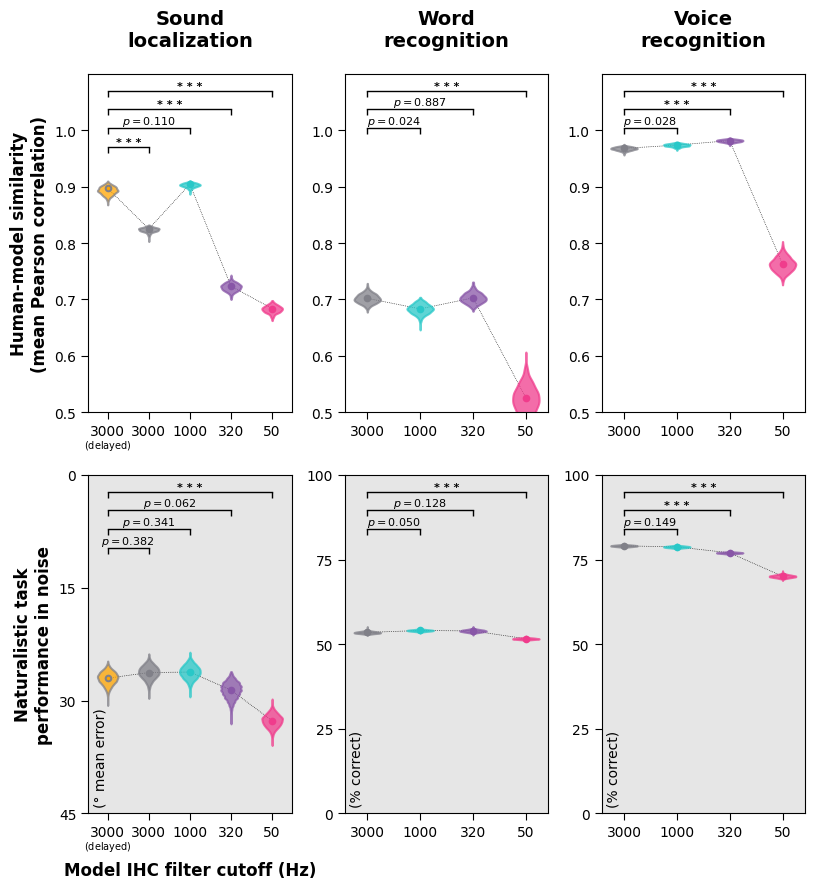

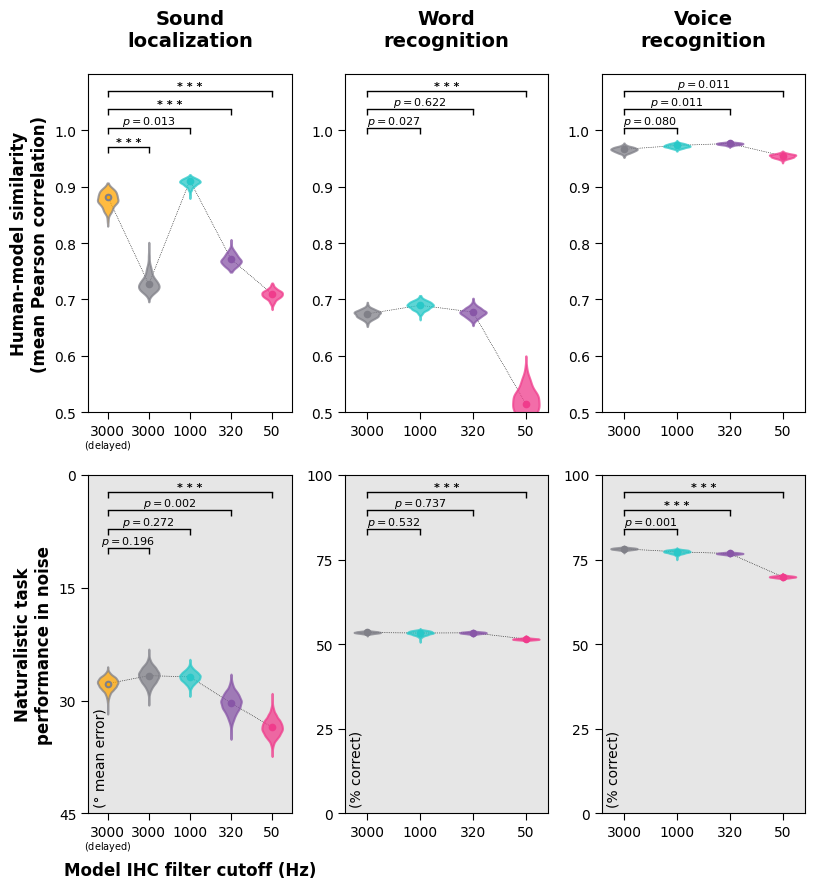

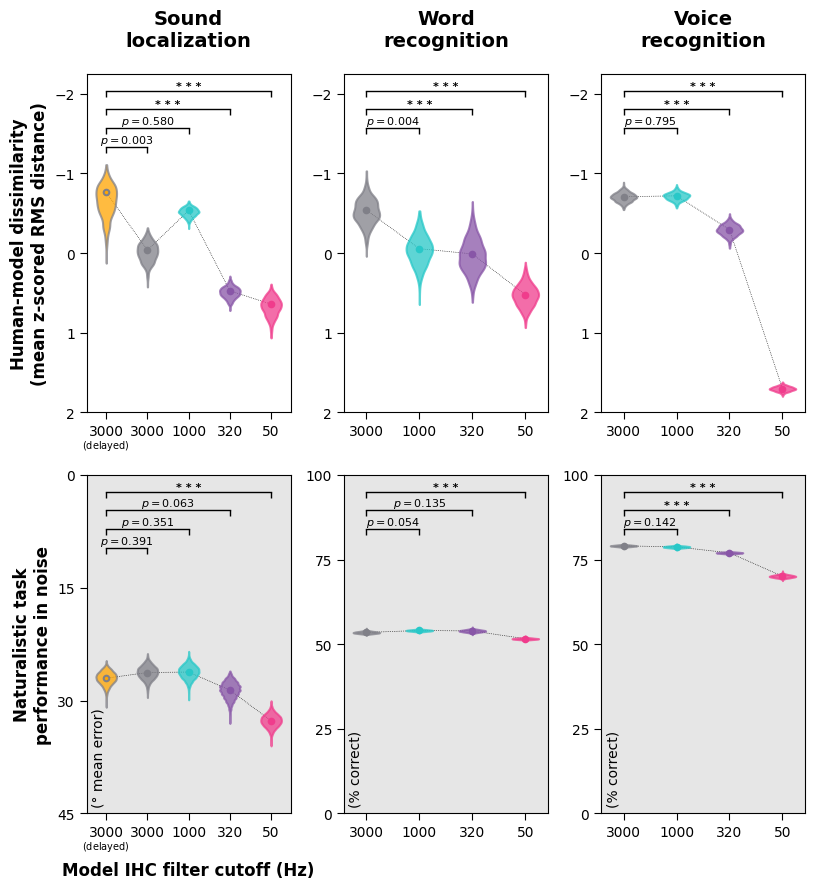

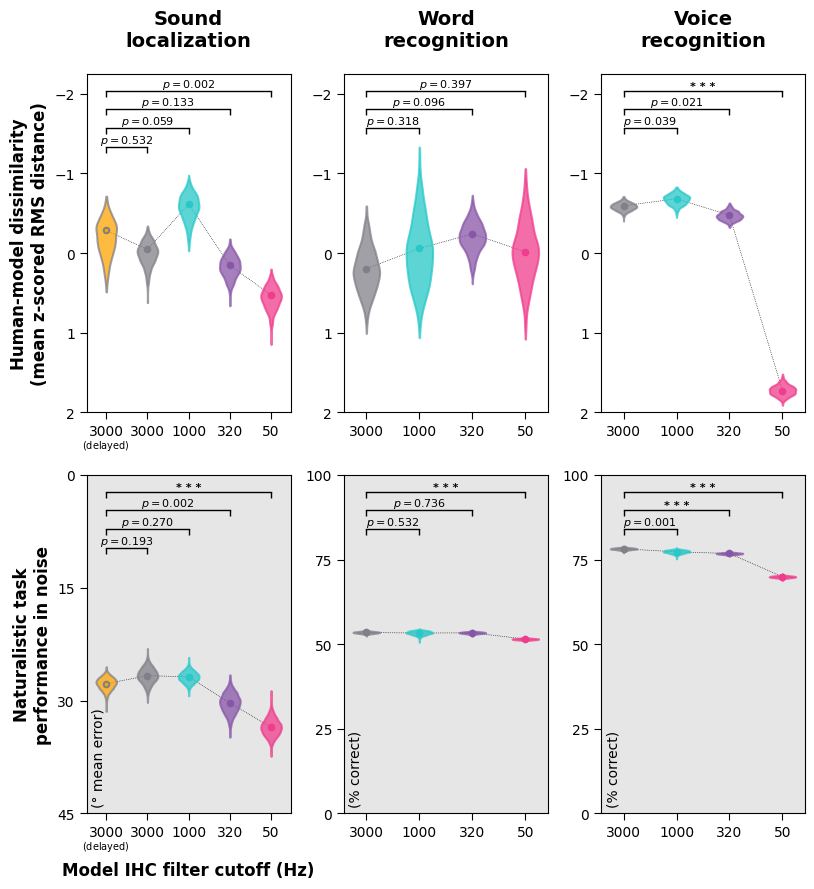

In [12]:
importlib.reload(util)

for (SIMPLE, ALTERNATE_METRIC) in [(0, 0), (1, 0), (0, 1), (1, 1)]:

    dict_list_k = {
        'localization': ['3000_delayed', '3000', '1000', '320', '50'],
        'word': ['3000', '1000', '320', '50'],
        'spkr': ['3000', '1000', '320', '50'],
    }
    if SIMPLE:
        for _ in dict_list_k.keys():
            dict_list_k[_] = [k + '_simple' for k in dict_list_k[_]]
    
    list_key_metric = [
        'rmse' if ALTERNATE_METRIC else 'pearsonr',
        {
            'localization': 'deg_err',
            'spkr': 'correct_spkr',
            'word': 'correct_word',
        },
    ]
    dict_kwargs_format_axes_update = {
        'pearsonr': {
            'ylimits': [0.5, 1.1],
            'yticks': np.arange(0.5, 1.01, 0.1),
            'str_xlabel': 'Model IHC filter cutoff (Hz)',
            'str_ylabel': 'Human-model similarity\n(mean Pearson correlation)',
        },
        'rmse': {
            'ylimits': [2, -2.25],
            'yticks': np.arange(2, -2.1, -1),
            'str_xlabel': 'Model IHC filter (Hz)',
            'str_ylabel': 'Human-model dissimilarity\n(mean z-scored RMS distance)',
        },
        'localization': {
            'ylimits': [45, 0],
            'yticks': np.arange(0, 46, 15),
            'str_xlabel': 'Model IHC filter cutoff (Hz)',
            'str_ylabel': 'Naturalistic task\nperformance in noise',
        },
        'spkr': {
            'ylimits': [0, 100],
            'yticks': np.arange(0, 101, 25),
            'str_xlabel': 'Model IHC filter (Hz)',
            'str_ylabel': 'Naturalistic task\nperformance in noise',
        },
        'word': {
            'ylimits': [0, 100],
            'yticks': np.arange(0, 101, 25),
            'str_xlabel': 'Model IHC filter (Hz)',
            'str_ylabel': 'Naturalistic task\nperformance in noise',
        },
    }
    
    nrows = len(list_key_metric)
    ncols = len(dict_list_k)
    
    fig, ax_arr = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(2.75 * ncols, 4.5 * nrows))
    
    
    for c, key_task in enumerate(dict_list_k.keys()):
        for r, key_metric_tmp in enumerate(list_key_metric):
            if isinstance(key_metric_tmp, dict):
                key_metric = key_metric_tmp[key_task]
                if 'localization' in key_task:
                    list_tag_model = [dict_tag_model['localization'][k] for k in dict_list_k[key_task]]
                    df = pd.read_pickle('data/model_data_localization.pkl')['snr_dependency']
                    df = df[np.logical_and.reduce([
                        df.tag_model.isin(list_tag_model),
                        np.isfinite(df.snr),
                    ])]
                else:
                    list_tag_model = [dict_tag_model['spkr_word'][k] for k in dict_list_k[key_task]]
                    df = pd.read_pickle('data/model_data_spkr_word.pkl')['kell_like']
                    df = df[np.logical_and.reduce([
                        df.tag_model.isin(list_tag_model),
                        df.snr.isin([-9, -6, -3, 0, 3, np.inf]),
                        df.background_condition.isin([0, 1, 2, 3]),
                    ])]
                df = df.groupby(['tag_model']).agg({
                    f'{key_metric}_list': list,
                }).reset_index()
                df[f'{key_metric}_list'] = df[f'{key_metric}_list'].map(lambda _: np.array(_).mean(axis=0))
                if 'correct' in key_metric:
                    df[f'{key_metric}_list'] = df[f'{key_metric}_list'].map(lambda _: 100 * np.array(_))
                df[f'{key_metric}'] = df[f'{key_metric}_list'].map(lambda _: np.mean(_))
                df[f'{key_metric}_sem'] = df[f'{key_metric}_list'].map(lambda _: np.std(_) / np.sqrt(len(_)))
                df[f'bootstrap_list_{key_metric}'] = df[f'{key_metric}_list'].map(
                    lambda _: np.random.choice(_, size=(10000, len(_))).mean(axis=1))
                kwargs_format_axes_update = dict(dict_kwargs_format_axes_update[key_task])
            else:
                key_metric = key_metric_tmp
                if key_task in ['spkr', 'word']:
                    df = pd.read_pickle('data/human_model_comparison_metrics_spkr_word.pkl')
                    list_tag_model = [dict_tag_model['spkr_word'][k] for k in dict_list_k[key_task]]
                    list_tag_expt = list(dict_tag_expt['spkr_word'].keys())
                    list_tag_expt = [_ for _ in list_tag_expt if key_task in _]
                else:
                    df = pd.read_pickle(f'data/human_model_comparison_metrics_{key_task}.pkl')
                    list_tag_model = [dict_tag_model[key_task][k] for k in dict_list_k[key_task]]
                    list_tag_expt = list(dict_tag_expt[key_task].keys())
                df = df[np.logical_and.reduce([
                    df.tag_model.isin(list_tag_model),
                    df.tag_expt.isin(list_tag_expt),
                ])]
                df = util.normalize_comparison_metrics(df)
                df = util.average_comparison_metrics(df)
                kwargs_format_axes_update = dict(dict_kwargs_format_axes_update[key_metric])
    
            kwargs_format_axes_update['fontweight_labels'] = 'bold'
            kwargs_format_axes_update['fontsize_ticks'] = 10
            if c > 0:
                kwargs_format_axes_update['str_ylabel'] = None
            if not ((c == 0) and (r == nrows - 1)):
                kwargs_format_axes_update['str_xlabel'] = None
            ax = ax_arr[r, c]
            ax = util.make_plot_comparison_metrics(
                ax,
                df=df,
                key_metric=key_metric,
                list_tag_model=list_tag_model,
                include_line=True,
                include_legend=False,
                kwargs_legend_update={},
                kwargs_format_axes_update=kwargs_format_axes_update)
            # if 'simple' in dict_list_k[key_task][0]:
            if r == 1:
                ax.set_facecolor([0.9] * 3)
            if r == 0:
                str_title = {
                    'localization': 'Sound\nlocalization',
                    'word': 'Word\nrecognition',
                    'spkr': 'Voice\nrecognition',
                }[key_task]
                ax.set_title(str_title, fontsize=14, fontweight=kwargs_format_axes_update['fontweight_labels'], pad=20)
            if isinstance(key_metric_tmp, dict):
                str_ylabel = '(° mean error)' if 'localization' in key_task else '(% correct)'
                ax.text(0.025, 0.020, str_ylabel, transform=ax.transAxes, va='bottom', ha='left', rotation=90, fontsize=10)
    
            import matplotlib.transforms
            list_y = np.arange(0.73, 1, 0.055)
            transform = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
            
            tag_model_null = list_tag_model[0]
            y_null = df[df.tag_model == tag_model_null].iloc[0][f'bootstrap_list_{key_metric}']
            for itr_model, tag_model in enumerate(list_tag_model[1:]):
                y = df[df.tag_model == tag_model].iloc[0][f'{key_metric}']
                y_dist = df[df.tag_model == tag_model].iloc[0][f'bootstrap_list_{key_metric}']
                p_val = get_p_val(y_null, y)
                d_val = util.cohend(y_null, y_dist)
                x = [0, itr_model + 1]
                y = [list_y[-(len(list_tag_model) - 1):][itr_model]] * len(x)
                str_text = '* * *' if p_val < 0.001 else '$p={:.3f}$'.format(p_val)
                ax.text(np.mean(x), np.mean(y), str_text, ha='center', va='bottom', fontsize=8, fontweight='bold', transform=transform)
                ax.plot(x, y, color='k', marker=3, ms=4, lw=1, mew=1, transform=transform)
    plt.tight_layout()
    plt.show()
    
    # fn_fig = f'figures_src/results_summary_grid.pdf'
    # if ALTERNATE_METRIC:
    #     fn_fig = fn_fig.replace('.pdf', '_alternate.pdf')
    # if 'simple' in dict_list_k[key_task][0]:
    #     fn_fig = fn_fig.replace('.pdf', '_simple.pdf')
    # fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=False)
    # print(fn_fig)


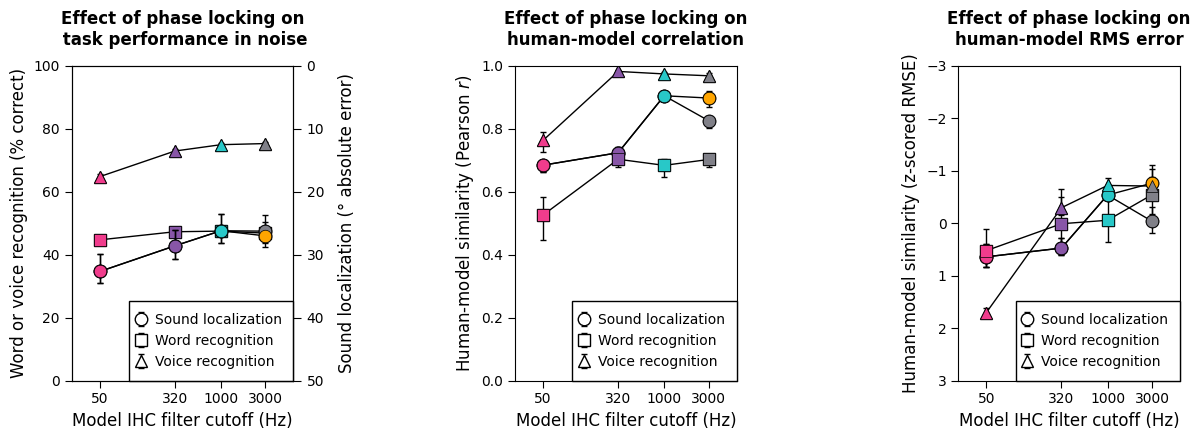

figures_src/results_summary_grid_alternate.pdf


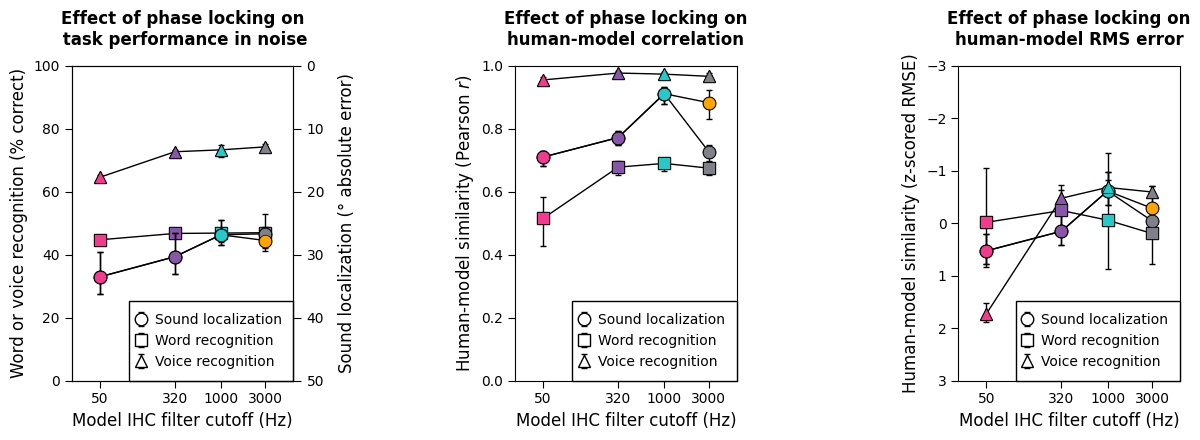

figures_src/results_summary_grid_alternate_simple.pdf


In [27]:
importlib.reload(util)

for (SIMPLE, ALTERNATE_METRIC) in [
        # (0, 0),
        # (1, 0),
        (0, 1),
        (1, 1)
    ]:

    list_dict_list_k = [
        {
            'localization': ['50', '320', '1000', '3000', '3000_delayed'],
            'word': ['50', '320', '1000', '3000'],
            'spkr': ['50', '320', '1000', '3000'],
        },
        # {
        # 'localization': ['50', '320', '1000', '3000', '3000_delayed'],
        # },
    ]
    for dict_list_k in list_dict_list_k:
        if SIMPLE:
            for _ in dict_list_k.keys():
                dict_list_k[_] = [k + '_simple' for k in dict_list_k[_]]
        list_key_metric = [
            {
                'spkr': 'correct_spkr',
                'localization': 'deg_err',
                'word': 'correct_word',
            },
            'pearsonr',
        ]
        if ALTERNATE_METRIC:
            list_key_metric.append('rmse')
        dict_kwargs_format_axes_update = {
            'pearsonr': {
                'ylimits': [0, 1],
                'yticks': np.arange(0.0, 1.01, 0.2),
                'str_ylabel': 'Human-model similarity (Pearson $r$)',
                'str_title': 'Effect of phase locking on\nhuman-model correlation',
            },
            'rmse': {
                'ylimits': [3, -3],
                'yticks': np.arange(3, -3.1, -1),
                'str_ylabel': 'Human-model similarity (z-scored RMSE)',
                'str_title': 'Effect of phase locking on\nhuman-model RMS error',
            },
        }
        kwargs_plot_update = {
            'localization': {'label': 'Sound localization', 'marker': 'o'},
            'word': {'label': 'Word recognition', 'marker': 's'},
            'spkr': {'label': 'Voice recognition', 'marker': '^'},
        }
        ncols = len(list_key_metric)
        fig, ax_arr = plt.subplots(nrows=1, ncols=ncols, figsize=(4 * ncols, 4.5), sharex=True)
        ax_arr = np.array(ax_arr).reshape([ncols])
        for itr_metric, key_metric_tmp in enumerate(list_key_metric):
            DOUBLE_AXIS = (isinstance(key_metric_tmp, dict)) and ('localization' in dict_list_k) and (len(dict_list_k) > 1)
            ax0 = ax_arr[itr_metric]
            for itr_task, key_task in enumerate(dict_list_k.keys()):
                if isinstance(key_metric_tmp, dict):
                    key_metric = key_metric_tmp[key_task]
                    if 'localization' in key_task:
                        list_tag_model = [dict_tag_model['localization'][k] for k in dict_list_k[key_task]]
                        df = pd.read_pickle('data/model_data_localization.pkl')['snr_dependency']
                        df = df[np.logical_and.reduce([
                            df.tag_model.isin(list_tag_model),
                            np.isfinite(df.snr),
                        ])]
                        ax1 = ax0.twinx() if DOUBLE_AXIS else ax0
                        ax = ax1
                    else:
                        list_tag_model = [dict_tag_model['spkr_word'][k] for k in dict_list_k[key_task]]
                        df = pd.read_pickle('data/model_data_spkr_word.pkl')['kell_like']
                        df = df[np.logical_and.reduce([
                            df.tag_model.isin(list_tag_model),
                            df.snr.isin([-9, -6, -3, 0, 3]),
                            df.background_condition.isin([0, 1, 2, 3]),
                        ])]
                        ax = ax0
                    df = df.groupby(['tag_model']).agg({
                        f'{key_metric}_list': list,
                    }).reset_index()
                    df[f'{key_metric}_list'] = df[f'{key_metric}_list'].map(lambda _: np.array(_).mean(axis=0))
                    if 'correct' in key_metric:
                        df[f'{key_metric}_list'] = df[f'{key_metric}_list'].map(lambda _: 100 * np.array(_))
                    df[f'{key_metric}'] = df[f'{key_metric}_list'].map(lambda _: np.mean(_))
                    df[f'{key_metric}_sem'] = df[f'{key_metric}_list'].map(lambda _: np.std(_) / np.sqrt(len(_)))
                    df[f'bootstrap_list_{key_metric}'] = df[f'{key_metric}_list'].map(
                        lambda _: np.random.choice(_, size=(10000, len(_))).mean(axis=1))
                    kwargs_format_axes_update = {}
                else:
                    ax = ax0
                    key_metric = key_metric_tmp
                    if key_task in ['spkr', 'word']:
                        df = pd.read_pickle('data/human_model_comparison_metrics_spkr_word.pkl')
                        list_tag_model = [dict_tag_model['spkr_word'][k] for k in dict_list_k[key_task]]
                        list_tag_expt = list(dict_tag_expt['spkr_word'].keys())
                        list_tag_expt = [_ for _ in list_tag_expt if key_task in _]
                    else:
                        df = pd.read_pickle(f'data/human_model_comparison_metrics_{key_task}.pkl')
                        list_tag_model = [dict_tag_model[key_task][k] for k in dict_list_k[key_task]]
                        list_tag_expt = list(dict_tag_expt[key_task].keys())
                    df = df[np.logical_and.reduce([
                        df.tag_model.isin(list_tag_model),
                        df.tag_expt.isin(list_tag_expt),
                    ])]
                    df = util.normalize_comparison_metrics(df)
                    df = util.average_comparison_metrics(df)
                    kwargs_format_axes_update = dict(dict_kwargs_format_axes_update[key_metric])
            
                x = np.array([map_tag_model_to_x(_) for _ in list_tag_model])
                y = np.array([df[df.tag_model == _].iloc[0][key_metric] for _ in list_tag_model])
                yerr = [df[df.tag_model == _].iloc[0][f'bootstrap_list_{key_metric}'] for _ in list_tag_model]
                yerr = np.abs(np.percentile(np.array(yerr), [0.0025, 0.9975], axis=1) - y)
                kwargs_errorbar = {
                    'color': 'k',
                    'capsize': 2,
                    'capthick': 1,
                    'elinewidth': 1,
                    'ls': '',
                    'ms': 9,
                    'lw': 1, #3 if DOUBLE_AXIS and key_task == 'localization' else 1,
                    'ls': '-', #':' if DOUBLE_AXIS and key_task == 'localization'else '-',
                    'mfc': 'w',
                    'zorder': -1,
                }
        
                kwargs_errorbar.update(kwargs_plot_update[key_task])
                if len(x) == 5:
                    ax.errorbar(x[:4], y[:4], yerr[:, :4], **kwargs_errorbar)
                    kwargs_errorbar.pop('label', None)
                    ax.errorbar(x[[0, 1, 2, 4]], y[[0, 1, 2, 4]], yerr[:, [0, 1, 2, 4]], **kwargs_errorbar)
                else:
                    ax.errorbar(x, y, yerr, **kwargs_errorbar)
                for x_, y_, tag_model in zip(x, y, list_tag_model):
                    color, _ = util.get_color_and_label_from_model_tag(tag_model)
                    if 'grouped' in tag_model:
                        color = 'orange'
                    kwargs_plot = {
                        'color': color,
                        'marker': kwargs_errorbar['marker'],
                        'ms': kwargs_errorbar['ms'],
                        'ls': '',
                        'markeredgecolor': 'k',
                        'mew': 0.5,
                    }
                    ax.plot(x_, y_, **kwargs_plot)
        
            kwargs_format_axes = {
                'xscale': 'log',
                'xlimits': [25, 6000],
                'xticks': x,
                'xticks_minor': [],
                'xticklabels': x,
                'ylimits': [0, 100],
                'yticks': np.arange(0, 101, 20),
                'str_ylabel': 'Word or voice recognition (% correct)',
                'str_xlabel': 'Model IHC filter cutoff (Hz)',
                'str_title': 'Effect of phase locking on\n task performance in noise',
                'fontweight_title': 'bold',
                'fontsize_ticks': 10,
            }
            if isinstance(key_metric_tmp, dict) and (not DOUBLE_AXIS):
                kwargs_format_axes['str_ylabel'] = 'Sound localization (° absolute error)'
                kwargs_format_axes['ylimits'] = [0, 50]
                kwargs_format_axes['yticks'] = np.arange(0, 51, 10)
        
            kwargs_format_axes.update(kwargs_format_axes_update)
            ax = util_figures.format_axes(ax, **kwargs_format_axes)
            if isinstance(key_metric_tmp, dict) and (not DOUBLE_AXIS):
                ax.invert_yaxis()
        
            h, l = ax.get_legend_handles_labels()
            if DOUBLE_AXIS:
                # ax.spines['right'].set_visible(0)
                ax1.invert_yaxis()
                yticks = np.arange(0, 51, 10)
                ax1.set_yticks(yticks)
                ax1.set_yticklabels(yticks, fontsize=12)
                ax1.set_ylabel('Sound localization (° absolute error)', fontsize=12, labelpad=10)
                # ax1.spines['right'].set_linestyle(':')
                # ax1.spines['right'].set_linewidth(3)
                # ax1.spines['right'].set_capstyle('butt')
                major_tick_params_kwargs = {
                    'axis': 'both',
                    'which': 'major',
                    'labelsize': 10,
                    'length': 12/2,
                    'direction': 'out',
                }
                ax1.tick_params(**major_tick_params_kwargs)
                h1, l1 = ax1.get_legend_handles_labels()
                h = h1 + h
                l = l1 + l
            if len(dict_list_k) > 1:
                kwargs_legend = {
                    'loc': 'lower right',
                    'frameon': True,
                    'framealpha': 1,
                    'edgecolor': 'k',
                    'facecolor': 'w',
                    'borderaxespad': 0,
                    'borderpad': 0.85,
                    'handlelength': 0,
                    'handletextpad': 1,
                    'markerscale': 1,
                    'fontsize': 10,
                    'fancybox': False,
                }
                # if isinstance(key_metric_tmp, dict):
                #     SORT_IDX = [0, 2, 1]
                #     h = [h[_] for _ in SORT_IDX]
                #     l = [l[_] for _ in SORT_IDX]
                ax.legend(h, l, **kwargs_legend)
            ax.set_title(ax.title.get_text(), pad=15, fontweight='bold')
        fig.tight_layout()
        fig.subplots_adjust(wspace=1)
        plt.show()

        fn_fig = f'figures_src/results_summary_grid.pdf'
        if len(dict_list_k) == 1:
            fn_fig = fn_fig.replace('.pdf', '_localization.pdf')
        if ALTERNATE_METRIC:
            fn_fig = fn_fig.replace('.pdf', '_alternate.pdf')
        if 'simple' in dict_list_k[key_task][0]:
            fn_fig = fn_fig.replace('.pdf', '_simple.pdf')
        fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=False)
        print(fn_fig)


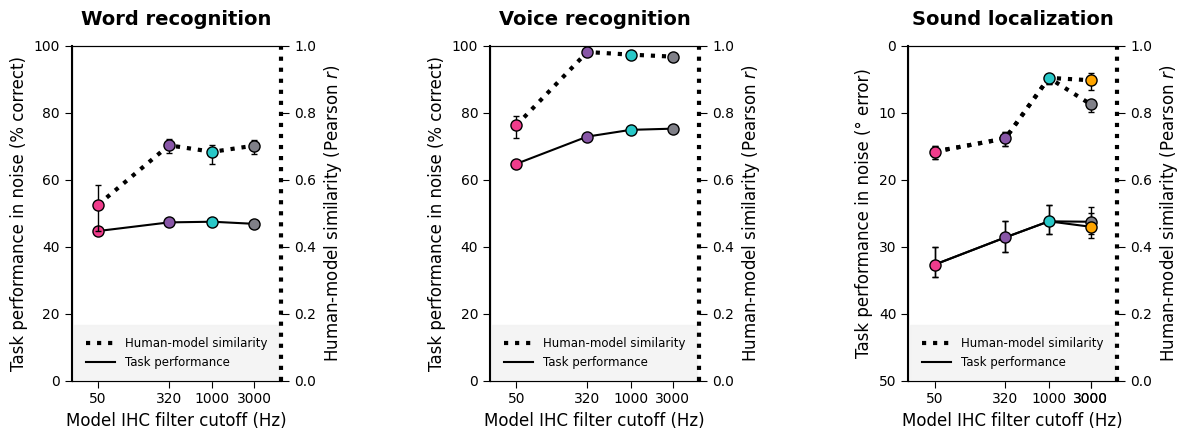

figures_poster/results_summary_by_task.pdf


In [2]:
poster = True
list_list_key_task = [
    ['localization', 'spkr', 'word'],
    ['localization'],
]
if poster:
    list_list_key_task = [['word', 'spkr', 'localization']]
for list_key_task in list_list_key_task:
    list_k = [
        '50',
        '320',
        '1000',
        '3000',
    ]
    if len(list_key_task) == 1 or poster:
        list_k.append('3000_delayed')
    dict_key_metric0 ={
        'localization': 'deg_err',
        'spkr': 'correct_spkr',
        'word': 'correct_word',
    }
    dict_key_metric1 ={
        'localization': 'pearsonr',
        'spkr': 'pearsonr',
        'word': 'pearsonr',
    }
    ncols = len(list_key_task)
    fig, ax_arr = plt.subplots(nrows=1, ncols=ncols, figsize=(max(4 * ncols, 4.5), 4.5))
    ax_arr = np.array(ax_arr).reshape([ncols])
    for itr0, key_task in enumerate(list_key_task):
        ax0 = ax_arr[itr0]
        ax1 = ax0.twinx()
        for itr1, (ax, dict_key_metric) in enumerate(zip([ax0, ax1], [dict_key_metric0, dict_key_metric1])):
            key_metric = dict_key_metric[key_task]
            if key_metric == 'pearsonr':
                if key_task in ['spkr', 'word']:
                    df = pd.read_pickle('data/human_model_comparison_metrics_spkr_word.pkl')
                    list_tag_model = [dict_tag_model['spkr_word'].get(k, None) for k in list_k]
                    list_tag_expt = list(dict_tag_expt['spkr_word'].keys())
                    list_tag_expt = [_ for _ in list_tag_expt if key_task in _]
                else:
                    df = pd.read_pickle(f'data/human_model_comparison_metrics_{key_task}.pkl')
                    list_tag_model = [dict_tag_model[key_task].get(k, None) for k in list_k]
                    list_tag_expt = list(dict_tag_expt[key_task].keys())
                df = df[np.logical_and.reduce([
                    df.tag_model.isin(list_tag_model),
                    df.tag_expt.isin(list_tag_expt),
                ])]
                df = util.normalize_comparison_metrics(df)
                df = util.average_comparison_metrics(df)
            else:
                if 'localization' in key_task:
                    list_tag_model = [dict_tag_model['localization'].get(k, None) for k in list_k]
                    df = pd.read_pickle('data/model_data_localization.pkl')['snr_dependency']
                    df = df[np.logical_and.reduce([
                        df.tag_model.isin(list_tag_model),
                        np.isfinite(df.snr),
                    ])]
                else:
                    list_tag_model = [dict_tag_model['spkr_word'].get(k, None) for k in list_k]
                    df = pd.read_pickle('data/model_data_spkr_word.pkl')['kell_like']
                    df = df[np.logical_and.reduce([
                        df.tag_model.isin(list_tag_model),
                        df.snr.isin([-9, -6, -3, 0, 3]),
                        df.background_condition.isin([0, 1, 2, 3]),
                    ])]
                df = df.groupby(['tag_model']).agg({
                    f'{key_metric}_list': list,
                }).reset_index()
                df[f'{key_metric}_list'] = df[f'{key_metric}_list'].map(lambda _: np.array(_).mean(axis=0))
                if 'correct' in key_metric:
                    df[f'{key_metric}_list'] = df[f'{key_metric}_list'].map(lambda _: 100 * np.array(_))
                df[f'{key_metric}'] = df[f'{key_metric}_list'].map(lambda _: np.mean(_))
                df[f'{key_metric}_sem'] = df[f'{key_metric}_list'].map(lambda _: np.std(_) / np.sqrt(len(_)))
                np.random.seed(0)
                df[f'bootstrap_list_{key_metric}'] = df[f'{key_metric}_list'].map(
                    lambda _: np.random.choice(_, size=(1000, len(_))).mean(axis=1))
            list_tag_model = [_ for _ in list_tag_model if _ is not None]
            x = np.array([map_tag_model_to_x(_) for _ in list_tag_model])
            y = np.array([df[df.tag_model == _].iloc[0][key_metric] for _ in list_tag_model])
            yerr = [df[df.tag_model == _].iloc[0][f'bootstrap_list_{key_metric}'] for _ in list_tag_model]
            yerr = np.abs(np.percentile(np.array(yerr), [0.0025, 0.9975], axis=1) - y)
            kwargs_errorbar = {
                'color': 'k',
                'capsize': 2,
                'capthick': 1,
                'elinewidth': 1,
                'ls': '',
                'marker': '',
                'lw': 3 if itr1 else 1.5,
                'ls': ':' if itr1 else '-',
                'zorder': -1,
                'label': 'Human-model similarity' if itr1 else 'Task performance',
            }
            if len(x) == 5:
                if len(list_key_task) == 1:
                    kwargs_errorbar.pop('label', None)
                ax.errorbar(x[:4], y[:4], yerr[:, :4], **kwargs_errorbar)
                kwargs_errorbar.pop('label', None)
                ax.errorbar(x[[0, 1, 2, 4]], y[[0, 1, 2, 4]], yerr[:, [0, 1, 2, 4]], **kwargs_errorbar)
                if len(list_key_task) == 1:
                    ax.plot(
                        [x[4] * 1.6] * 2,
                        y[3:],
                        marker=0,
                        color='k',
                        lw=2,
                        mew=2,
                        ms=4)
                    y_null = df[df.tag_model == list_tag_model[-2]].iloc[0][f'bootstrap_list_{key_metric}']
                    y_dist = df[df.tag_model == list_tag_model[-1]].iloc[0][f'bootstrap_list_{key_metric}']
                    y_test = df[df.tag_model == list_tag_model[-1]].iloc[0][f'{key_metric}']
                    p_val = get_p_val(y_null, y_test)
                    print('Comparison: {} vs {}, p={:.4f}, d_pg={:.4f}, d_util={:.4f}'.format(
                        list_k[-2],
                        list_k[-1],
                        p_val,
                        pg.compute_effsize(y_null, y_dist, paired=False, eftype='cohen'),
                        util.cohend(y_null, y_dist),
                    ))
                    str_text = '$p<0.001$' if p_val < 0.001 else '$p={:.3f}$'.format(p_val)
                    ax.text(
                        x[4] * 2,
                        np.exp(np.mean(np.log(y[3:]))),
                        str_text,
                        ha='left',
                        va='center',
                        fontsize=10,
                        fontweight='bold')
            else:
                ax.errorbar(x, y, yerr, **kwargs_errorbar)
            for x_, y_, tag_model in zip(x, y, list_tag_model):
                color, _ = util.get_color_and_label_from_model_tag(tag_model)
                kwargs_plot = {
                    'color': color,
                    'marker': 'o',
                    'ms': 8,
                    'ls': '',
                    'markeredgecolor': 'k',
                    'mew': 1,
                }
                if 'grouped' in tag_model:
                    kwargs_plot['color'] = 'orange'
                    if len(list_key_task) == 1:
                        kwargs_plot['label'] = '(delayed interaural integration)'
                ax.plot(x_, y_, **kwargs_plot)
            kwargs_format_axes = {
                'xlimits': [25, 6000] if len(list_key_task) > 1 else [25, 6000 * 8],
                'xscale': 'log',
                'xticks': x,
                'xticks_minor': [],
                'xticklabels': x,
                'fontsize_ticks': 10,
                'str_xlabel': 'Model IHC filter cutoff (Hz)',
            }
            if 'err' in key_metric:
                kwargs_format_axes_update = {
                    'ylimits': [50, 0],
                    'yticks': [50, 40, 30, 20, 10, 0],
                    'str_ylabel': 'Task performance in noise (° error)',
                    'str_title': 'Sound localization',
                }
            elif 'correct' in key_metric:
                kwargs_format_axes_update = {
                    'ylimits': [0, 100],
                    'yticks': [0, 20, 40, 60, 80, 100],
                    'str_ylabel': 'Task performance in noise (% correct)',
                    'str_title': '{} recognition'.format('Word' if key_task == 'word' else 'Voice'),
                }
            else:
                kwargs_format_axes_update = {
                    'ylimits': [0, 1],
                    'yticks': [0, 0.2, 0.4, 0.6, 0.8, 1.0],
                    'str_ylabel': 'Human-model similarity (Pearson $r$)'
                }
            kwargs_format_axes.update(kwargs_format_axes_update)
            ax = util_figures.format_axes(ax, **kwargs_format_axes)
            if itr1:
                ax0.set_title(ax0.title.get_text(), pad=15, fontweight='bold', fontsize=14)
                ax1.spines['left'].set_linewidth(1.5)
                ax0.spines['right'].set_visible(0)
                ax1.spines['right'].set_linestyle(':')
                ax1.spines['right'].set_linewidth(3)
                ax1.spines['right'].set_capstyle('butt')
                major_tick_params_kwargs = {
                    'axis': 'both',
                    'which': 'major',
                    'labelsize': 10,
                    'length': 12/2,
                    'direction': 'out',
                }
                ax1.tick_params(**major_tick_params_kwargs)
            if len(x) == 5 and len(list_key_task) == 1:
                kwargs_legend = {
                    'loc': 'lower center',
                    'frameon': True,
                    'fancybox': False,
                    'edgecolor': 'k',
                    'borderaxespad': 0,
                    'borderpad': 1.0,
                    'markerscale': 1.25,
                    'handlelength': 1,
                }
                ax0.legend(**kwargs_legend)
            else:
                h0, l0 = ax0.get_legend_handles_labels()
                h1, l1 = ax1.get_legend_handles_labels()
                h = h1 + h0
                l = l1 + l0
                h = [_[0] for _ in h]
                kwargs_legend = {
                    'loc': 'lower center',
                    'frameon': True,
                    'fancybox': False,
                    'edgecolor': [0.95] * 3,
                    'facecolor': [0.95] * 3,
                    'borderaxespad': 0,
                    'borderpad': 1,
                    'markerscale': 0,
                    'handlelength': 2.5,
                    'fontsize': 8.5,
                }
                leg = ax0.legend(h, l, **kwargs_legend)
    fig.tight_layout()
    fig.subplots_adjust(wspace=1)
    plt.show()

    fn_fig = f'figures_src/results_summary_by_task.pdf'
    if poster:
        fn_fig = f'figures_poster/results_summary_by_task.pdf'
    if len(list_key_task) == 1:
        fn_fig = fn_fig.replace('.pdf', '_localization.pdf')
    fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=False)
    print(fn_fig)


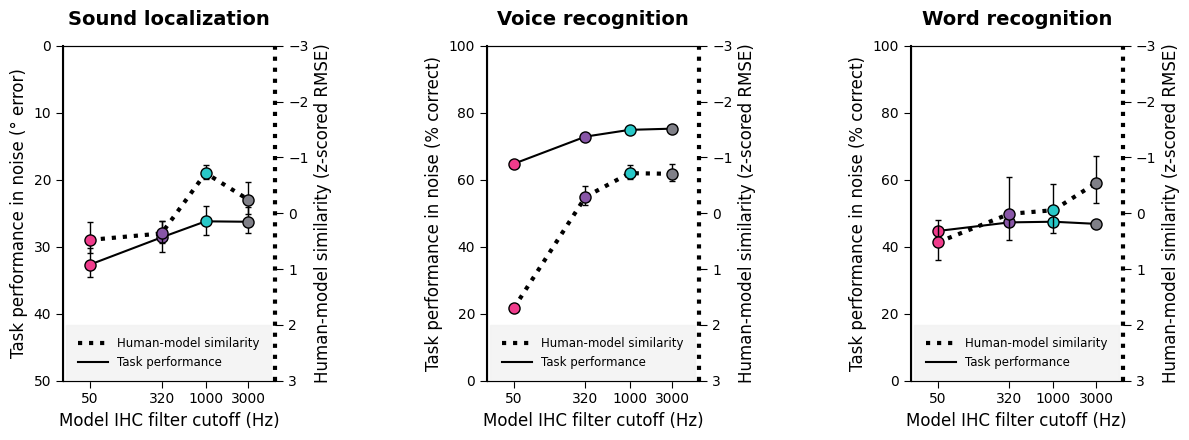

figures_src/results_summary_by_task_alternate.pdf


In [25]:
list_key_task = ['localization', 'spkr', 'word']
list_k = [
    '50',
    '320',
    '1000',
    '3000',
]
dict_key_metric0 ={
    'localization': 'deg_err',
    'spkr': 'correct_spkr',
    'word': 'correct_word',
}
dict_key_metric1 ={
    'localization': 'rmse',
    'spkr': 'rmse',
    'word': 'rmse',
}
ncols = len(list_key_task)
fig, ax_arr = plt.subplots(nrows=1, ncols=ncols, figsize=(4 * ncols, 4.5))
ax_arr = np.array(ax_arr).reshape([ncols])
for itr0, key_task in enumerate(list_key_task):
    ax0 = ax_arr[itr0]
    ax1 = ax0.twinx()
    for itr1, (ax, dict_key_metric) in enumerate(zip([ax0, ax1], [dict_key_metric0, dict_key_metric1])):
        key_metric = dict_key_metric[key_task]
        if key_metric == 'rmse':
            if key_task in ['spkr', 'word']:
                df = pd.read_pickle('data/human_model_comparison_metrics_spkr_word.pkl')
                list_tag_model = [dict_tag_model['spkr_word'][k] for k in list_k]
                list_tag_expt = list(dict_tag_expt['spkr_word'].keys())
                list_tag_expt = [_ for _ in list_tag_expt if key_task in _]
            else:
                df = pd.read_pickle(f'data/human_model_comparison_metrics_{key_task}.pkl')
                list_tag_model = [dict_tag_model[key_task][k] for k in list_k]
                list_tag_expt = list(dict_tag_expt[key_task].keys())
            df = df[np.logical_and.reduce([
                df.tag_model.isin(list_tag_model),
                df.tag_expt.isin(list_tag_expt),
            ])]
            df = util.normalize_comparison_metrics(df)
            df = util.average_comparison_metrics(df)
        else:
            if 'localization' in key_task:
                list_tag_model = [dict_tag_model['localization'][k] for k in list_k]
                df = pd.read_pickle('data/model_data_localization.pkl')['snr_dependency']
                df = df[np.logical_and.reduce([
                    df.tag_model.isin(list_tag_model),
                    np.isfinite(df.snr),
                ])]
            else:
                list_tag_model = [dict_tag_model['spkr_word'][k] for k in list_k]
                df = pd.read_pickle('data/model_data_spkr_word.pkl')['kell_like']
                df = df[np.logical_and.reduce([
                    df.tag_model.isin(list_tag_model),
                    df.snr.isin([-9, -6, -3, 0, 3]),
                    df.background_condition.isin([0, 1, 2, 3]),
                ])]
            df = df.groupby(['tag_model']).agg({
                f'{key_metric}_list': list,
            }).reset_index()
            df[f'{key_metric}_list'] = df[f'{key_metric}_list'].map(lambda _: np.array(_).mean(axis=0))
            if 'correct' in key_metric:
                df[f'{key_metric}_list'] = df[f'{key_metric}_list'].map(lambda _: 100 * np.array(_))
            df[f'{key_metric}'] = df[f'{key_metric}_list'].map(lambda _: np.mean(_))
            df[f'{key_metric}_sem'] = df[f'{key_metric}_list'].map(lambda _: np.std(_) / np.sqrt(len(_)))
            df[f'bootstrap_list_{key_metric}'] = df[f'{key_metric}_list'].map(
                lambda _: np.random.choice(_, size=(1000, len(_))).mean(axis=1))
        x = np.array([map_tag_model_to_x(_) for _ in list_tag_model])
        y = np.array([df[df.tag_model == _].iloc[0][key_metric] for _ in list_tag_model])
        yerr = [df[df.tag_model == _].iloc[0][f'bootstrap_list_{key_metric}'] for _ in list_tag_model]
        yerr = np.abs(np.percentile(np.array(yerr), [0.0025, 0.9975], axis=1) - y)
        kwargs_errorbar = {
            'color': 'k',
            'capsize': 2,
            'capthick': 1,
            'elinewidth': 1,
            'ls': '',
            'marker': '',
            'lw': 3 if itr1 else 1.5,
            'ls': ':' if itr1 else '-',
            'zorder': -1,
            'label': 'Human-model similarity' if itr1 else 'Task performance',
        }
        ax.errorbar(x, y, yerr, **kwargs_errorbar)
        for x_, y_, tag_model in zip(x, y, list_tag_model):
            color, _ = util.get_color_and_label_from_model_tag(tag_model)
            kwargs_plot = {
                'color': color,
                'marker': 'o',
                'ms': 8,
                'ls': '',
                'markeredgecolor': 'k',
                'mew': 1,
            }
            if 'grouped' in tag_model:
                kwargs_plot['color'] = 'orange'
                kwargs_plot['label'] = '(delayed integration)'
            ax.plot(x_, y_, **kwargs_plot)
        kwargs_format_axes = {
            'xlimits': [25, 6000] if len(list_key_task) > 1 else [25, 6000 * 8],
            'xscale': 'log',
            'xticks': x,
            'xticks_minor': [],
            'xticklabels': x,
            'fontsize_ticks': 10,
            'str_xlabel': 'Model IHC filter cutoff (Hz)',
        }
        if 'err' in key_metric:
            kwargs_format_axes_update = {
                'ylimits': [50, 0],
                'yticks': [50, 40, 30, 20, 10, 0],
                'str_ylabel': 'Task performance in noise (° error)',
                'str_title': 'Sound localization',
            }
        elif 'correct' in key_metric:
            kwargs_format_axes_update = {
                'ylimits': [0, 100],
                'yticks': [0, 20, 40, 60, 80, 100],
                'str_ylabel': 'Task performance in noise (% correct)',
                'str_title': '{} recognition'.format('Word' if key_task == 'word' else 'Voice'),
            }
        elif 'rmse' in key_metric:
            kwargs_format_axes_update = {
                'ylimits': [3, -3],
                'yticks': np.arange(3, -3.1, -1),
                'str_ylabel': 'Human-model similarity (z-scored RMSE)',
            }
        else:
            kwargs_format_axes_update = {
                'ylimits': [0, 1],
                'yticks': [0, 0.2, 0.4, 0.6, 0.8, 1.0],
                'str_ylabel': 'Human-model similarity (Pearson $r$)'
            }
        kwargs_format_axes.update(kwargs_format_axes_update)
        ax = util_figures.format_axes(ax, **kwargs_format_axes)
        if itr1:
            ax0.set_title(ax0.title.get_text(), pad=15, fontweight='bold', fontsize=14)
            ax1.spines['left'].set_linewidth(1.5)
            ax0.spines['right'].set_visible(0)
            ax1.spines['right'].set_linestyle(':')
            ax1.spines['right'].set_linewidth(3)
            ax1.spines['right'].set_capstyle('butt')
            major_tick_params_kwargs = {
                'axis': 'both',
                'which': 'major',
                'labelsize': 10,
                'length': 12/2,
                'direction': 'out',
            }
            ax1.tick_params(**major_tick_params_kwargs)
        h0, l0 = ax0.get_legend_handles_labels()
        h1, l1 = ax1.get_legend_handles_labels()
        h = h1 + h0
        l = l1 + l0
        h = [_[0] for _ in h]
        kwargs_legend = {
            'loc': 'lower center',
            'frameon': True,
            'fancybox': False,
            'edgecolor': [0.95] * 3,
            'facecolor': [0.95] * 3,
            'borderaxespad': 0,
            'borderpad': 1,
            'markerscale': 0,
            'handlelength': 2.5,
            'fontsize': 8.5,
        }
        leg = ax0.legend(h, l, **kwargs_legend)
fig.tight_layout()
fig.subplots_adjust(wspace=1)
plt.show()

fn_fig = f'figures_src/results_summary_by_task_alternate.pdf'
fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=False)
print(fn_fig)


In [24]:
list_key_task = [
    'localization',
    'spkr',
    'word',
]

list_key_metric = [
    {
        'spkr': 'correct_spkr',
        'localization': 'deg_err',
        'word': 'correct_word',
    },
    # 'pearsonr',
]

list_k = [
    '3000',
    '1000',
    '320',
    '50',
]
for key_task in list_key_task:
    for key_metric_tmp in list_key_metric:
        if isinstance(key_metric_tmp, dict):
            key_metric = key_metric_tmp[key_task]
            if 'localization' in key_task:
                list_tag_model = [dict_tag_model['localization'][k] for k in list_k]
                df = pd.read_pickle('data/model_data_localization.pkl')['snr_dependency']
                df = df[np.logical_and.reduce([
                    df.tag_model.isin(list_tag_model),
                    np.isfinite(df.snr),
                ])]
            else:
                list_tag_model = [dict_tag_model['spkr_word'][k] for k in list_k]
                df = pd.read_pickle('data/model_data_spkr_word.pkl')['kell_like']
                df = df[np.logical_and.reduce([
                    df.tag_model.isin(list_tag_model),
                    df.snr.isin([-9, -6, -3, 0, 3]),
                    df.background_condition.isin([0, 1, 2, 3]),
                ])]
            df = df.groupby(['tag_model']).agg({
                f'{key_metric}_list': list,
            }).reset_index()
            df[f'{key_metric}_list'] = df[f'{key_metric}_list'].map(lambda _: np.array(_).mean(axis=0))
            if 'correct' in key_metric:
                df[f'{key_metric}_list'] = df[f'{key_metric}_list'].map(lambda _: 100 * np.array(_))
            df[f'{key_metric}'] = df[f'{key_metric}_list'].map(lambda _: np.mean(_))
            df[f'{key_metric}_sem'] = df[f'{key_metric}_list'].map(lambda _: np.std(_) / np.sqrt(len(_)))
            np.random.seed(0)
            df[f'bootstrap_list_{key_metric}'] = df[f'{key_metric}_list'].map(
                lambda _: np.random.choice(_, size=(1000, len(_))).mean(axis=1))
        else:
            key_metric = key_metric_tmp
            if key_task in ['spkr', 'word']:
                df = pd.read_pickle('data/human_model_comparison_metrics_spkr_word.pkl')
                list_tag_model = [dict_tag_model['spkr_word'][k] for k in list_k]
                list_tag_expt = list(dict_tag_expt['spkr_word'].keys())
                list_tag_expt = [_ for _ in list_tag_expt if key_task in _]
            else:
                df = pd.read_pickle(f'data/human_model_comparison_metrics_{key_task}.pkl')
                list_tag_model = [dict_tag_model[key_task][k] for k in list_k]
                list_tag_expt = list(dict_tag_expt[key_task].keys())
            df = df[np.logical_and.reduce([
                df.tag_model.isin(list_tag_model),
                df.tag_expt.isin(list_tag_expt),
            ])]
            df = util.normalize_comparison_metrics(df)
            df = util.average_comparison_metrics(df)

        print('\n\n######', key_task, key_metric)
        x = df.iloc[0][f'{key_metric}_list']
        y = df.iloc[-1][f'{key_metric}_list']
        y_null = df[df.tag_model == list_tag_model[0]].iloc[0][f'bootstrap_list_{key_metric}']
        y_dist = df[df.tag_model == list_tag_model[-1]].iloc[0][f'bootstrap_list_{key_metric}']
        y_test = df[df.tag_model == list_tag_model[-1]].iloc[0][f'{key_metric}']
        p_val = get_p_val(y_null, y_test)
        print('{} model comparison: {} vs {}, p={:.4f}, d_pg={:.4f}, d_util={:.4f}, diff_in_mean={:.4f} ({})'.format(
            key_task,
            list_k[-1],
            list_k[0],
            p_val,
            pg.compute_effsize(y_null, y_dist, paired=False, eftype='cohen'),
            util.cohend(y_null, y_dist),
            df.iloc[0][key_metric] - df.iloc[-1][key_metric],
            key_metric,
        ))        
        # print(key_task, key_metric, df.iloc[-1][key_metric] - df.iloc[0][key_metric])
        # print(key_task, key_metric, np.abs(util.cohend(x, y)), x.shape, y.shape, scipy.stats.ttest_ind(x, y))
        print('\n', pg.ttest(x, y, paired=False))
        # print(pg.mwu(x, y))

        # df_statistics = df.copy()
        # df_statistics['fn_eval_list'] = df_statistics[f'{key_metric}_list'].map(lambda _: list(range(len(_))))
        # df_statistics = df_statistics.explode([f'{key_metric}_list', 'fn_eval_list'])
        # df_statistics[f'{key_metric}_list'] = df_statistics[f'{key_metric}_list'].astype(float)        
        # aov = pg.anova(
        #     data=df_statistics,
        #     dv=f'{key_metric}_list',
        #     between='tag_model',
        #     effsize='np2')
        # # aov = pg.rm_anova(
        # #     data=df_statistics,
        # #     dv=f'{key_metric}_list',
        # #     subject='fn_eval_list',
        # #     within='tag_model',
        # #     effsize='np2')
        # print(aov)




###### localization deg_err
localization model comparison: 50 vs 3000, p=0.0000, d_pg=-7.4010, d_util=7.4047, diff_in_mean=6.4034 (deg_err)

                T  dof alternative     p-val         CI95%  cohen-d     BF10  \
T-test  5.022007   18   two-sided  0.000089  [3.72, 9.08]  2.24591  218.599   

           power  
T-test  0.997279  


###### spkr correct_spkr
spkr model comparison: 50 vs 3000, p=0.0000, d_pg=28.7848, d_util=-28.7992, diff_in_mean=-10.5027 (correct_spkr)

                T  dof alternative         p-val            CI95%   cohen-d  \
T-test -19.46642   18   two-sided  1.535465e-13  [-11.64, -9.37]  8.705648   

             BF10  power  
T-test  2.044e+10    1.0  


###### word correct_word
word model comparison: 50 vs 3000, p=0.0000, d_pg=7.7915, d_util=-7.7954, diff_in_mean=-2.1396 (correct_word)

                T  dof alternative     p-val           CI95%   cohen-d  \
T-test -5.154954   18   two-sided  0.000066  [-3.01, -1.27]  2.305366   

           BF10     

In [21]:
# list_key_task = [
#     'localization',
#     'spkr',
#     'word',
# ]

# dict_key_metric ={
#     'spkr': 'correct_spkr_mean',
#     'localization': 'deg_err_mean',
#     'word': 'correct_word_mean',
# }

# list_k = [
#     '3000',
#     '1000',
#     '320',
#     '50',
# ]
# for key_task in list_key_task:
#     key_metric = dict_key_metric[key_task]
#     if 'localization' in key_task:
#         list_tag_model = [dict_tag_model['localization'][k] for k in list_k]
#         df = pd.read_pickle('data/model_data_localization.pkl')['snr_dependency']
#         df = df[np.logical_and.reduce([
#             df.tag_model.isin(list_tag_model),
#             np.isfinite(df.snr),
#         ])]
#     else:
#         list_tag_model = [dict_tag_model['spkr_word'][k] for k in list_k]
#         df = pd.read_pickle('data/model_data_spkr_word.pkl')['kell_like']
#         df = df[np.logical_and.reduce([
#             df.tag_model.isin(list_tag_model),
#             df.snr.isin([-9, -6, -3, 0, 3]),
#             df.background_condition.isin([0, 1, 2, 3]),
#         ])]
#         df = df.groupby(['tag_model', 'snr']).agg({key_metric: 'mean'}).reset_index()
#     print(df.snr.unique())
#     df = df.groupby(['tag_model']).agg({
#         key_metric: list,
#     }).reset_index()
#     x = df.iloc[0][f'{key_metric}']
#     y = df.iloc[-1][f'{key_metric}']
#     # print(key_task, key_metric, len(x), len(y), util.cohend(x, y))
#     # print(key_task, key_metric, np.abs(util.cohend(x, y)), len(x), len(y), scipy.stats.ttest_rel(x, y))
#     print(pg.wilcoxon(x, y))


In [22]:
# key_metric = 'pearsonr'
# for key_task in list_key_task:
#     if key_task in ['spkr', 'word']:
#         df = pd.read_pickle('data/human_model_comparison_metrics_spkr_word.pkl')
#         list_tag_model = [dict_tag_model['spkr_word'][k] for k in list_k]
#         list_tag_expt = list(dict_tag_expt['spkr_word'].keys())
#         list_tag_expt = [_ for _ in list_tag_expt if key_task in _]
#     else:
#         df = pd.read_pickle(f'data/human_model_comparison_metrics_{key_task}.pkl')
#         list_tag_model = [dict_tag_model[key_task][k] for k in list_k]
#         list_tag_expt = list(dict_tag_expt[key_task].keys())
#     df = df[np.logical_and.reduce([
#         df.tag_model.isin(list_tag_model),
#         df.tag_expt.isin(list_tag_expt),
#     ])]
#     df = util.normalize_comparison_metrics(df)
#     # df = util.average_comparison_metrics(df)
#     df = df.groupby(['tag_model']).agg({
#         key_metric: list,
#     }).reset_index()
#     x = df.iloc[0][f'{key_metric}']
#     y = df.iloc[-1][f'{key_metric}']
#     print(key_task, key_metric, len(x), len(y), util.cohend(x, y))
